# dataset

In [ ]:
!wget http://ufldl.stanford.edu/housenumbers/train_32x32.mat -P /content/
!wget http://ufldl.stanford.edu/housenumbers/test_32x32.mat -P /content/

--2024-05-31 06:07:29--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘/content/train_32x32.mat’

train_32x32.mat     100%[===================>] 173.61M  3.65MB/s    in 59s     

2024-05-31 06:08:29 (2.93 MB/s) - ‘/content/train_32x32.mat’ saved [182040794/182040794]

--2024-05-31 06:08:29--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘/content/test_32x32.mat’

test_32x32.mat      100%[===================>]  61.30M  1.99MB/s    in 69s     

2024-05-31 06:09:38 (910 KB/s) - ‘/content

In [ ]:
import pandas as pd
from scipy.io import loadmat
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

def load_svhn_data(mat_file_path):
    mat = loadmat(mat_file_path)
    data = mat['X']
    labels = mat['y'].astype(np.int64).squeeze()
    labels[labels == 10] = 0
    data = np.transpose(data, (3, 0, 1, 2))
    return data, labels

train_data, train_labels = load_svhn_data('/content/train_32x32.mat')
train_df = pd.DataFrame({'data': list(train_data), 'class': train_labels})
df = train_df

label_encoder = LabelEncoder()
df['class_encoded'] = label_encoder.fit_transform(df['class'])

X = df['data']
y = df['class_encoded']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)


In [ ]:
import os

import numpy as np

from torch.utils.data import Dataset

class AircraftDataset(Dataset):
    def __init__(self, images, classes, transform=None):
        self.transform = transform
        self.images = images
        self.classes = classes

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images.iloc[idx]

        if self.transform is not None:
            augmented = self.transform(image=image)
            image = augmented['image']

        return image, self.classes.iloc[idx]

In [ ]:

from torch.utils.data import DataLoader
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim

def get_loader(images,
               classes,
               transform,
               batch_size,
               num_workers=8,
               pin_memory=True,
               ):
    tmp = AircraftDataset(images=images, classes=classes, transform=transform)
    loader = DataLoader(tmp, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory, shuffle=True)

    return loader

IMAGE_HEIGHT = 32
IMAGE_WIDTH = 32

transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

batch_size = 8

train_data_loader = get_loader(
    images=X_train,
    classes=y_train,
    transform=transform,
    batch_size=batch_size)
val_data_loader = get_loader(
    images=X_val,
    classes=y_val,
    transform=transform,
    batch_size=batch_size)
test_data_loader = get_loader(
    images=X_test,
    classes=y_test,
    transform=transform,
    batch_size=batch_size)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Custom Layers

In [ ]:
import math
import torch
from torch import nn
from collections import OrderedDict

class LinearLayer(nn.Module):
    def __init__(self, input_features, output_features, bias=True):
        super(LinearLayer, self).__init__()
        self.input_features = input_features
        self.output_features = output_features
        self.weight = nn.Parameter(torch.Tensor(output_features, input_features))
        self.bias = nn.Parameter(torch.Tensor(output_features)) if bias else None
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            bound = 1 / math.sqrt(self.input_features)
            nn.init.uniform_(self.bias, -bound, bound)

    def forward(self, input):
        output = input.matmul(self.weight.t())
        if self.bias is not None:
            output += self.bias
        return output

class ReLULayer(nn.Module):
    def forward(self, input):
        return torch.relu(input)


class AircraftNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, batch_normalization=False):
        super(AircraftNet, self).__init__()
        layers = [
            ('fc1', LinearLayer(input_size, hidden_size)),
            ('relu1', ReLULayer()),
            ('fc2', LinearLayer(hidden_size, output_size))
        ]
        if batch_normalization:
            layers.insert(1, ('bn1', nn.BatchNorm1d(hidden_size)))
            layers.append(('bn2', nn.BatchNorm1d(output_size)))
        self.model = nn.Sequential(OrderedDict(layers))

    def forward(self, x):
        return self.model(x)


# Train

In [ ]:
def check_gradients(model, input_data, target_data, loss_fn, epsilon=1e-5, num_params_to_check=10):
    input_data = input_data.view(-1, IMAGE_HEIGHT*IMAGE_WIDTH*3).to(device)
    target_data = target_data.to(device)
    model.zero_grad()
    loss = loss_fn(model(input_data), target_data)
    loss.backward()

    params_to_check = list(model.named_parameters())
    num_params = sum(p[1].numel() for p in params_to_check if p[1].requires_grad)
    if num_params_to_check > num_params:
        num_params_to_check = num_params

    indices = torch.randperm(num_params)[:num_params_to_check]

    for param_name, param in params_to_check:
        if param.requires_grad:
            print(f"Checking gradient for parameter: {param_name}")

            grad = param.grad
            param_flat = param.data.view(-1)
            grad_flat = grad.view(-1)

            for idx in indices:
                if idx >= param_flat.size(0):
                    break

                param_flat[idx] += epsilon
                loss_plus = loss_fn(model(input_data), target_data)
                param_flat[idx] -= 2 * epsilon
                loss_minus = loss_fn(model(input_data), target_data)
                param_flat[idx] += epsilon

                numerical_grad = (loss_plus - loss_minus) / (2 * epsilon)
                diff = torch.abs(numerical_grad - grad_flat[idx]).item()

                if diff > epsilon:
                    print(f'Gradient check failed for parameter {param_name}')
                    return False

    print('Gradients check passed!')
    return True


In [ ]:
import torch
import torch.nn as nn
import pandas as pd
from tqdm import tqdm

def train_model(model, optimizer_class, train_loader, val_loader, num_epochs, learning_rate, weight_decay, results_df):
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optimizer_class(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    train_losses = []
    val_losses = []
    best_acc = 0.0

    def run_epoch(loader, is_training=False):
        epoch_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (images, labels) in enumerate(tqdm(loader)):
            images = images.view(-1, IMAGE_HEIGHT * IMAGE_WIDTH * 3).to(device)
            labels = labels.to(device)

            model.train() if is_training else model.eval()

            with torch.set_grad_enabled(is_training):
                outputs = model(images)
                loss = criterion(outputs, labels)

                if is_training:
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

            epoch_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_accuracy = correct / total
        return epoch_loss / len(loader), epoch_accuracy

    for epoch in range(num_epochs):
        train_loss, train_accuracy = run_epoch(train_loader, is_training=True)
        train_losses.append(train_loss)

        val_loss, val_accuracy = run_epoch(val_loader)
        val_losses.append(val_loss)

        print(f'Epoch [{epoch + 1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Accuracy: {train_accuracy * 100:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Accuracy: {val_accuracy * 100:.2f}%')

        best_acc = max(best_acc, val_accuracy)

    new_results = pd.DataFrame({
        "optimizer": [str(optimizer).split('(')[0].strip()],
        "best_accuracy": [best_acc],
        "learning_rate": [learning_rate],
        "weight_decay": [weight_decay]
    })
    updated_results_df = pd.concat([results_df, new_results])

    return train_losses, val_losses, updated_results_df

results_df = pd.DataFrame(columns=['optimizer', 'best_accuracy', 'learning_rate', 'weight_decay'])


# Adam

In [ ]:
import torch
from torch import nn
from torch.optim.optimizer import Optimizer
import math
from typing import Dict, Any, Tuple, Optional

class AdaptiveOptimizer(Optimizer):
    def __init__(self, parameters, settings: Dict[str, Any], learning_rate: float, momentum_factors: Tuple[float, float], epsilon: float):
        settings.update(dict(lr=learning_rate, betas=momentum_factors, eps=epsilon))
        super().__init__(parameters, settings)

    def prepare_state(self, state: Dict[str, any], config: Dict[str, any], tensor: nn.Parameter):
        pass

    def update_param(self, state: Dict[str, any], config: Dict[str, any], gradient: torch.Tensor, tensor: torch.Tensor):
        pass

    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for config in self.param_groups:
            for tensor in config['params']:
                if tensor.grad is None:
                    continue
                gradient = tensor.grad.data
                state = self.state[tensor]
                if len(state) == 0:
                    self.prepare_state(state, config, tensor)
                self.update_param(state, config, gradient, tensor)

        return loss


class DecayRegularizer:
    def __init__(self, decay_rate: float = 0., decouple_decay: bool = True, absolute_decay: bool = False):
        self.absolute_decay = absolute_decay
        self.decouple_decay = decouple_decay
        self.decay_rate = decay_rate

    def defaults(self):
        return dict(weight_decay=self.decay_rate)

    def __call__(self, tensor: torch.nn.Parameter, gradient: torch.Tensor, config: Dict[str, any]):
        if self.decouple_decay:
            if self.absolute_decay:
                tensor.data.mul_(1.0 - config['weight_decay'])
            else:
                tensor.data.mul_(1.0 - config['lr'] * config['weight_decay'])
            return gradient
        else:
            if config['weight_decay'] != 0:
                return gradient.add(tensor.data, alpha=config['weight_decay'])
            else:
                return gradient

class Adam(AdaptiveOptimizer):

    def __init__(self, parameters,
                 learning_rate: float = 1e-3, momentum_factors: Tuple[float, float] = (0.9, 0.999), epsilon: float = 1e-16,
                 decay_rate: float = 0,
                 efficient_update: bool = True,
                 settings: Optional[Dict[str, Any]] = None):

        settings = {} if settings is None else settings
        decay_regularizer = DecayRegularizer(decay_rate=decay_rate)
        settings.update(decay_regularizer.defaults())
        super().__init__(parameters, settings, learning_rate, momentum_factors, epsilon)
        self.decay_regularizer = decay_regularizer
        self.efficient_update = efficient_update

    def prepare_state(self, state: Dict[str, any], config: Dict[str, any], tensor: nn.Parameter):
        state['iteration'] = 0
        state['mean_gradient'] = torch.zeros_like(tensor, memory_format=torch.preserve_format)
        state['squared_gradient'] = torch.zeros_like(tensor, memory_format=torch.preserve_format)

    def compute_momentum(self, state: Dict[str, Any], config: Dict[str, Any], gradient: torch.Tensor):
        beta1, beta2 = config['betas']
        mean_grad, squared_grad = state['mean_gradient'], state['squared_gradient']
        mean_grad.mul_(beta1).add_(gradient, alpha=1 - beta1)
        squared_grad.mul_(beta2).addcmul_(gradient, gradient, value=1 - beta2)

        return mean_grad, squared_grad

    def compute_learning_rate(self, state: Dict[str, any], config: Dict[str, any]):
        return config['lr']

    def adam_optimization(self, state: Dict[str, any], config: Dict[str, any], tensor: torch.nn.Parameter,
                          mean_grad: torch.Tensor, squared_grad: torch.Tensor):
        beta1, beta2 = config['betas']
        correction1 = 1 - beta1 ** state['iteration']
        correction2 = 1 - beta2 ** state['iteration']
        learning_rate = self.compute_learning_rate(state, config)
        if self.efficient_update:
            denominator = squared_grad.sqrt().add_(config['eps'])
            step_size = learning_rate * math.sqrt(correction2) / correction1
            tensor.data.addcdiv_(mean_grad, denominator, value=-step_size)
        else:
            denominator = (squared_grad.sqrt() / math.sqrt(correction2)).add_(config['eps'])
            step_size = learning_rate / correction1
            tensor.data.addcdiv_(mean_grad, denominator, value=-step_size)

    def update_param(self, state: Dict[str, any], config: Dict[str, any], gradient: torch.Tensor, tensor: torch.nn.Parameter):
        gradient = self.decay_regularizer(tensor, gradient, config)
        mean_grad, squared_grad = self.compute_momentum(state, config, gradient)
        state['iteration'] += 1
        self.adam_optimization(state, config, tensor, mean_grad, squared_grad)


In [ ]:
import numpy as np
import random
import torch
import pandas as pd
from sklearn.preprocessing import LabelEncoder

SEED_VALUE = 42
device = "cuda" if torch.cuda.is_available() else "cpu"

def set_seed(seed=SEED_VALUE):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed()

Params lr=0.0001, w=0.0001, opt=SGD


  0%|          | 0/6410 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1374/1374 [00:09<00:00, 137.49it/s]


Epoch [1/10], Train Loss: 2.2466, Accuracy: 18.76%, Val Loss: 2.2387, Accuracy: 18.80%


100%|██████████| 1374/1374 [00:05<00:00, 258.54it/s]


Epoch [2/10], Train Loss: 2.2403, Accuracy: 18.96%, Val Loss: 2.2368, Accuracy: 18.81%


100%|██████████| 1374/1374 [00:05<00:00, 254.84it/s]


Epoch [3/10], Train Loss: 2.2382, Accuracy: 18.97%, Val Loss: 2.2340, Accuracy: 18.83%


100%|██████████| 1374/1374 [00:07<00:00, 179.25it/s]


Epoch [4/10], Train Loss: 2.2361, Accuracy: 18.97%, Val Loss: 2.2320, Accuracy: 18.84%


100%|██████████| 1374/1374 [00:05<00:00, 261.26it/s]


Epoch [5/10], Train Loss: 2.2337, Accuracy: 19.02%, Val Loss: 2.2297, Accuracy: 19.07%


100%|██████████| 1374/1374 [00:05<00:00, 250.20it/s]


Epoch [6/10], Train Loss: 2.2312, Accuracy: 19.10%, Val Loss: 2.2272, Accuracy: 18.96%


100%|██████████| 1374/1374 [00:05<00:00, 257.26it/s]


Epoch [7/10], Train Loss: 2.2285, Accuracy: 19.23%, Val Loss: 2.2247, Accuracy: 18.90%


100%|██████████| 1374/1374 [00:08<00:00, 167.99it/s]


Epoch [8/10], Train Loss: 2.2255, Accuracy: 19.30%, Val Loss: 2.2215, Accuracy: 19.29%


100%|██████████| 1374/1374 [00:05<00:00, 255.59it/s]


Epoch [9/10], Train Loss: 2.2223, Accuracy: 19.52%, Val Loss: 2.2185, Accuracy: 19.20%


100%|██████████| 1374/1374 [00:05<00:00, 262.08it/s]


Epoch [10/10], Train Loss: 2.2190, Accuracy: 19.68%, Val Loss: 2.2153, Accuracy: 19.46%


100%|██████████| 1374/1374 [00:07<00:00, 171.79it/s]


Test Accuracy: 19.64%


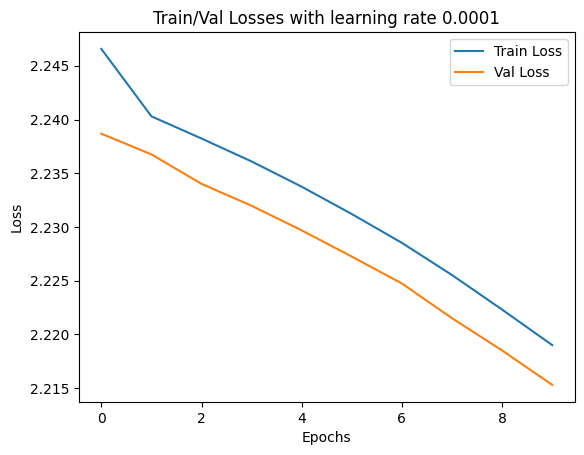

train_losses=[2.2465673360177396, 2.240294140456433, 2.2382296227627725, 2.2360961169608857, 2.2337445767546966, 2.2312018262986646, 2.228519172527117, 2.225526581706941, 2.2223105016439084, 2.2190058852878636]
[2.238678376053445, 2.236752660947769, 2.234009757486146, 2.231971361925161, 2.229681129452096, 2.227242641226867, 2.224739858503772, 2.221506277806894, 2.2185065070441023, 2.2153040884710644]
Params lr=0.0001, w=0.01, opt=SGD


100%|██████████| 1374/1374 [00:08<00:00, 163.96it/s]


Epoch [1/10], Train Loss: 2.2513, Accuracy: 18.14%, Val Loss: 2.2367, Accuracy: 18.81%


100%|██████████| 1374/1374 [00:05<00:00, 262.27it/s]


Epoch [2/10], Train Loss: 2.2399, Accuracy: 18.94%, Val Loss: 2.2347, Accuracy: 18.81%


100%|██████████| 1374/1374 [00:05<00:00, 266.04it/s]


Epoch [3/10], Train Loss: 2.2380, Accuracy: 18.94%, Val Loss: 2.2336, Accuracy: 18.81%


100%|██████████| 1374/1374 [00:07<00:00, 191.12it/s]


Epoch [4/10], Train Loss: 2.2362, Accuracy: 18.94%, Val Loss: 2.2312, Accuracy: 18.81%


100%|██████████| 1374/1374 [00:05<00:00, 264.50it/s]


Epoch [5/10], Train Loss: 2.2342, Accuracy: 18.94%, Val Loss: 2.2296, Accuracy: 18.81%


100%|██████████| 1374/1374 [00:05<00:00, 262.07it/s]


Epoch [6/10], Train Loss: 2.2322, Accuracy: 18.94%, Val Loss: 2.2278, Accuracy: 18.81%


100%|██████████| 1374/1374 [00:05<00:00, 259.88it/s]


Epoch [7/10], Train Loss: 2.2301, Accuracy: 18.94%, Val Loss: 2.2259, Accuracy: 18.85%


100%|██████████| 1374/1374 [00:07<00:00, 181.28it/s]


Epoch [8/10], Train Loss: 2.2279, Accuracy: 18.94%, Val Loss: 2.2233, Accuracy: 18.81%


100%|██████████| 1374/1374 [00:05<00:00, 253.99it/s]


Epoch [9/10], Train Loss: 2.2255, Accuracy: 18.94%, Val Loss: 2.2206, Accuracy: 18.85%


100%|██████████| 1374/1374 [00:05<00:00, 263.71it/s]


Epoch [10/10], Train Loss: 2.2231, Accuracy: 18.96%, Val Loss: 2.2185, Accuracy: 18.85%


100%|██████████| 1374/1374 [00:07<00:00, 185.17it/s]


Test Accuracy: 18.96%


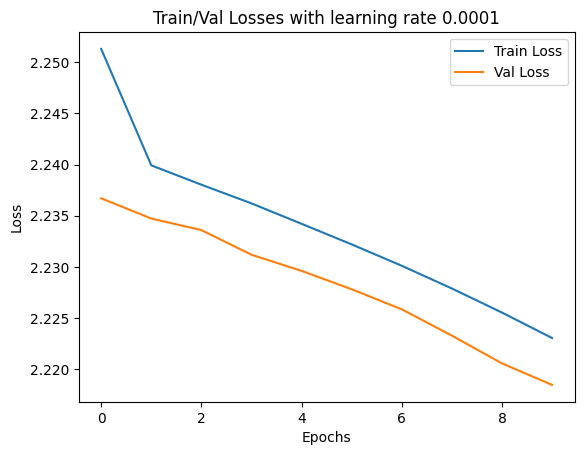

train_losses=[2.251304192792235, 2.2399278163537963, 2.2380358410513903, 2.236209324871694, 2.2342151182490095, 2.2322025624526645, 2.2301135872157984, 2.227891909555414, 2.2255403794290123, 2.223052666469967]
[2.2367081775762454, 2.234731524879061, 2.2335991700663835, 2.2311929499044516, 2.2296165123777096, 2.2278176622446275, 2.2258580341783327, 2.223288088299475, 2.220573531748426, 2.2184715425430253]
Params lr=0.001, w=0.0001, opt=SGD


100%|██████████| 1374/1374 [00:05<00:00, 255.28it/s]


Epoch [1/10], Train Loss: 2.2384, Accuracy: 19.07%, Val Loss: 2.2230, Accuracy: 19.61%


100%|██████████| 1374/1374 [00:05<00:00, 265.06it/s]


Epoch [2/10], Train Loss: 2.2085, Accuracy: 20.18%, Val Loss: 2.1818, Accuracy: 20.55%


100%|██████████| 1374/1374 [00:08<00:00, 170.98it/s]


Epoch [3/10], Train Loss: 2.1432, Accuracy: 24.11%, Val Loss: 2.0907, Accuracy: 27.77%


100%|██████████| 1374/1374 [00:05<00:00, 254.97it/s]


Epoch [4/10], Train Loss: 2.0178, Accuracy: 31.23%, Val Loss: 1.9395, Accuracy: 34.95%


100%|██████████| 1374/1374 [00:05<00:00, 256.62it/s]


Epoch [5/10], Train Loss: 1.8540, Accuracy: 38.89%, Val Loss: 1.7726, Accuracy: 43.50%


100%|██████████| 1374/1374 [00:07<00:00, 181.74it/s]


Epoch [6/10], Train Loss: 1.6989, Accuracy: 45.01%, Val Loss: 1.6417, Accuracy: 49.90%


100%|██████████| 1374/1374 [00:05<00:00, 259.61it/s]


Epoch [7/10], Train Loss: 1.5697, Accuracy: 50.72%, Val Loss: 1.5163, Accuracy: 54.95%


100%|██████████| 1374/1374 [00:05<00:00, 264.11it/s]


Epoch [8/10], Train Loss: 1.4650, Accuracy: 55.35%, Val Loss: 1.4198, Accuracy: 58.38%


100%|██████████| 1374/1374 [00:08<00:00, 167.45it/s]


Epoch [9/10], Train Loss: 1.3791, Accuracy: 58.99%, Val Loss: 1.3449, Accuracy: 58.70%


100%|██████████| 1374/1374 [00:05<00:00, 260.81it/s]


Epoch [10/10], Train Loss: 1.3086, Accuracy: 61.71%, Val Loss: 1.2849, Accuracy: 61.65%


100%|██████████| 1374/1374 [00:05<00:00, 265.17it/s]


Test Accuracy: 61.12%


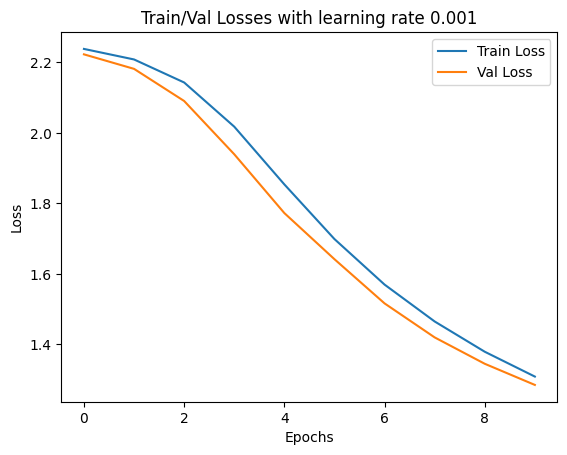

train_losses=[2.2384315078046506, 2.2085273342087937, 2.1431816497198692, 2.0177987165830436, 1.8539536616080636, 1.698854803044041, 1.5696560183757924, 1.46498375629858, 1.3790835643939778, 1.3085977971274843]
[2.2230387205987343, 2.181845173825343, 2.090656146472198, 1.939489985310528, 1.7725847389500213, 1.6416897026298696, 1.5162980064554505, 1.4197819630738777, 1.3449255976787995, 1.2849153598019476]
Params lr=0.001, w=0.01, opt=SGD


100%|██████████| 1374/1374 [00:08<00:00, 165.58it/s]


Epoch [1/10], Train Loss: 2.2359, Accuracy: 19.03%, Val Loss: 2.2195, Accuracy: 18.93%


100%|██████████| 1374/1374 [00:05<00:00, 250.59it/s]


Epoch [2/10], Train Loss: 2.2042, Accuracy: 20.45%, Val Loss: 2.1782, Accuracy: 20.25%


100%|██████████| 1374/1374 [00:05<00:00, 274.01it/s]


Epoch [3/10], Train Loss: 2.1410, Accuracy: 23.95%, Val Loss: 2.0957, Accuracy: 25.90%


100%|██████████| 1374/1374 [00:06<00:00, 208.46it/s]


Epoch [4/10], Train Loss: 2.0343, Accuracy: 29.40%, Val Loss: 1.9725, Accuracy: 32.12%


100%|██████████| 1374/1374 [00:05<00:00, 257.74it/s]


Epoch [5/10], Train Loss: 1.9053, Accuracy: 35.81%, Val Loss: 1.8425, Accuracy: 39.08%


100%|██████████| 1374/1374 [00:05<00:00, 268.56it/s]


Epoch [6/10], Train Loss: 1.7836, Accuracy: 41.05%, Val Loss: 1.7349, Accuracy: 42.24%


100%|██████████| 1374/1374 [00:05<00:00, 260.96it/s]


Epoch [7/10], Train Loss: 1.6806, Accuracy: 45.20%, Val Loss: 1.6362, Accuracy: 47.36%


100%|██████████| 1374/1374 [00:07<00:00, 181.03it/s]


Epoch [8/10], Train Loss: 1.5967, Accuracy: 48.85%, Val Loss: 1.5735, Accuracy: 48.13%


100%|██████████| 1374/1374 [00:05<00:00, 252.57it/s]


Epoch [9/10], Train Loss: 1.5270, Accuracy: 51.91%, Val Loss: 1.5063, Accuracy: 52.48%


100%|██████████| 1374/1374 [00:05<00:00, 262.23it/s]


Epoch [10/10], Train Loss: 1.4699, Accuracy: 54.31%, Val Loss: 1.4732, Accuracy: 54.61%


100%|██████████| 1374/1374 [00:07<00:00, 177.47it/s]


Test Accuracy: 53.98%


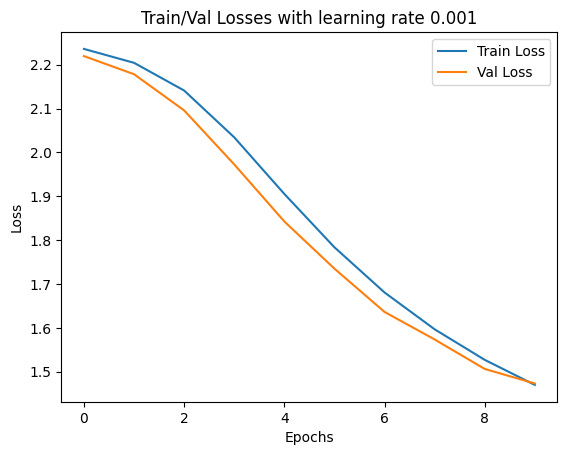

train_losses=[2.235866727453312, 2.2041659830512943, 2.1409961949458545, 2.0342894821010775, 1.9052744695809256, 1.783594733560327, 1.6806330707999362, 1.5966811111397379, 1.52702358849521, 1.4698925842547008]
[2.2195066963220786, 2.1781935141770252, 2.0956871460098365, 1.9725472549684182, 1.842482887674801, 1.7349418753099233, 1.6362430038150222, 1.5734972148222695, 1.5062718533272306, 1.4731939988972664]
Params lr=0.01, w=0.0001, opt=SGD


100%|██████████| 1374/1374 [00:05<00:00, 264.85it/s]


Epoch [1/10], Train Loss: 2.0495, Accuracy: 27.46%, Val Loss: 1.6656, Accuracy: 45.29%


100%|██████████| 1374/1374 [00:05<00:00, 257.75it/s]


Epoch [2/10], Train Loss: 1.4650, Accuracy: 51.86%, Val Loss: 1.3108, Accuracy: 58.98%


100%|██████████| 1374/1374 [00:05<00:00, 270.62it/s]


Epoch [3/10], Train Loss: 1.2514, Accuracy: 60.31%, Val Loss: 1.6166, Accuracy: 47.35%


100%|██████████| 1374/1374 [00:06<00:00, 203.33it/s]


Epoch [4/10], Train Loss: 1.1540, Accuracy: 63.92%, Val Loss: 1.2594, Accuracy: 59.21%


100%|██████████| 1374/1374 [00:05<00:00, 261.21it/s]


Epoch [5/10], Train Loss: 1.0881, Accuracy: 66.19%, Val Loss: 1.0117, Accuracy: 68.97%


100%|██████████| 1374/1374 [00:05<00:00, 267.46it/s]


Epoch [6/10], Train Loss: 1.0393, Accuracy: 67.76%, Val Loss: 1.0311, Accuracy: 66.73%


100%|██████████| 1374/1374 [00:08<00:00, 168.73it/s]


Epoch [7/10], Train Loss: 1.0010, Accuracy: 69.35%, Val Loss: 0.9975, Accuracy: 69.23%


100%|██████████| 1374/1374 [00:05<00:00, 261.07it/s]


Epoch [8/10], Train Loss: 0.9607, Accuracy: 70.57%, Val Loss: 0.9229, Accuracy: 71.71%


100%|██████████| 1374/1374 [00:05<00:00, 268.34it/s]


Epoch [9/10], Train Loss: 0.9283, Accuracy: 71.51%, Val Loss: 0.9808, Accuracy: 69.85%


100%|██████████| 1374/1374 [00:06<00:00, 196.82it/s]


Epoch [10/10], Train Loss: 0.9006, Accuracy: 72.49%, Val Loss: 0.8887, Accuracy: 73.63%


100%|██████████| 1374/1374 [00:05<00:00, 266.13it/s]


Test Accuracy: 72.64%


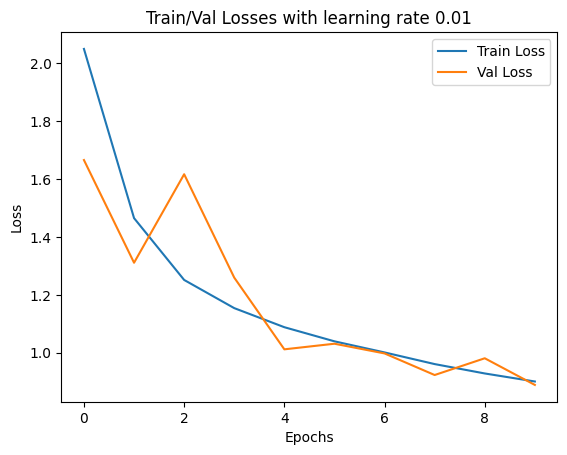

train_losses=[2.0495129192768133, 1.4649654260896112, 1.2513852020228708, 1.1540381524647918, 1.0881226168245124, 1.0393342312256837, 1.0010008469915566, 0.9607344397935034, 0.9283322667031783, 0.9005684043973824]
[1.6656285467539986, 1.3108364943160067, 1.6165936241113463, 1.2593747519900185, 1.0116888766747723, 1.031052038718823, 0.9975356997290336, 0.9229338031256736, 0.980813347741289, 0.8887357568257154]
Params lr=0.01, w=0.01, opt=SGD


100%|██████████| 1374/1374 [00:05<00:00, 269.58it/s]


Epoch [1/10], Train Loss: 2.1105, Accuracy: 24.58%, Val Loss: 1.8003, Accuracy: 40.80%


100%|██████████| 1374/1374 [00:06<00:00, 203.71it/s]


Epoch [2/10], Train Loss: 1.6124, Accuracy: 46.50%, Val Loss: 1.4452, Accuracy: 53.81%


100%|██████████| 1374/1374 [00:05<00:00, 263.05it/s]


Epoch [3/10], Train Loss: 1.4285, Accuracy: 54.22%, Val Loss: 1.5249, Accuracy: 48.98%


100%|██████████| 1374/1374 [00:05<00:00, 232.50it/s]


Epoch [4/10], Train Loss: 1.3623, Accuracy: 57.03%, Val Loss: 1.2743, Accuracy: 61.63%


100%|██████████| 1374/1374 [00:07<00:00, 180.89it/s]


Epoch [5/10], Train Loss: 1.3283, Accuracy: 58.84%, Val Loss: 1.2776, Accuracy: 60.58%


100%|██████████| 1374/1374 [00:05<00:00, 261.65it/s]


Epoch [6/10], Train Loss: 1.3098, Accuracy: 59.29%, Val Loss: 1.2715, Accuracy: 61.42%


100%|██████████| 1374/1374 [00:05<00:00, 253.96it/s]


Epoch [7/10], Train Loss: 1.3021, Accuracy: 59.63%, Val Loss: 1.2775, Accuracy: 60.22%


100%|██████████| 1374/1374 [00:07<00:00, 186.45it/s]


Epoch [8/10], Train Loss: 1.2922, Accuracy: 60.14%, Val Loss: 1.3370, Accuracy: 55.59%


100%|██████████| 1374/1374 [00:05<00:00, 260.72it/s]


Epoch [9/10], Train Loss: 1.2886, Accuracy: 60.44%, Val Loss: 1.2468, Accuracy: 59.52%


100%|██████████| 1374/1374 [00:05<00:00, 253.72it/s]


Epoch [10/10], Train Loss: 1.2835, Accuracy: 60.32%, Val Loss: 1.2546, Accuracy: 63.16%


100%|██████████| 1374/1374 [00:08<00:00, 165.11it/s]


Test Accuracy: 63.14%


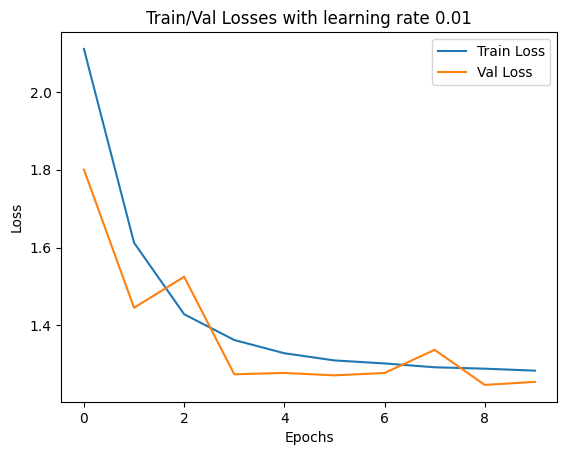

train_losses=[2.110498275492753, 1.612391038631872, 1.428533578635006, 1.362311255420426, 1.3282598793692597, 1.3098320221659174, 1.3020614807138018, 1.292203127361497, 1.288572847694391, 1.2835254932482045]
[1.8003111045259923, 1.4451705894746114, 1.5248875642490873, 1.2742513711665915, 1.2776096299225586, 1.271471873771676, 1.277513848490243, 1.3369935973068858, 1.2468458816864605, 1.2546485277242536]
Params lr=0.0001, w=0.0001, opt=Adam


100%|██████████| 1374/1374 [00:05<00:00, 256.71it/s]


Epoch [1/10], Train Loss: 2.2026, Accuracy: 19.77%, Val Loss: 2.1274, Accuracy: 24.85%


100%|██████████| 1374/1374 [00:08<00:00, 159.03it/s]


Epoch [2/10], Train Loss: 2.0440, Accuracy: 26.53%, Val Loss: 1.9514, Accuracy: 30.79%


100%|██████████| 1374/1374 [00:05<00:00, 255.41it/s]


Epoch [3/10], Train Loss: 1.8671, Accuracy: 35.60%, Val Loss: 1.7858, Accuracy: 41.57%


100%|██████████| 1374/1374 [00:07<00:00, 174.59it/s]


Epoch [4/10], Train Loss: 1.7296, Accuracy: 41.82%, Val Loss: 1.6752, Accuracy: 45.09%


100%|██████████| 1374/1374 [00:05<00:00, 257.17it/s]


Epoch [5/10], Train Loss: 1.6119, Accuracy: 46.53%, Val Loss: 1.5622, Accuracy: 49.50%


100%|██████████| 1374/1374 [00:08<00:00, 167.62it/s]


Epoch [6/10], Train Loss: 1.5140, Accuracy: 50.74%, Val Loss: 1.4831, Accuracy: 51.61%


100%|██████████| 1374/1374 [00:05<00:00, 246.40it/s]


Epoch [7/10], Train Loss: 1.4414, Accuracy: 53.79%, Val Loss: 1.4146, Accuracy: 54.67%


100%|██████████| 1374/1374 [00:06<00:00, 215.14it/s]


Epoch [8/10], Train Loss: 1.3833, Accuracy: 56.46%, Val Loss: 1.3770, Accuracy: 56.71%


100%|██████████| 1374/1374 [00:05<00:00, 248.03it/s]


Epoch [9/10], Train Loss: 1.3337, Accuracy: 58.55%, Val Loss: 1.3126, Accuracy: 60.13%


100%|██████████| 1374/1374 [00:07<00:00, 189.99it/s]


Epoch [10/10], Train Loss: 1.2943, Accuracy: 60.14%, Val Loss: 1.2838, Accuracy: 60.62%


100%|██████████| 1374/1374 [00:05<00:00, 251.66it/s]


Test Accuracy: 59.95%


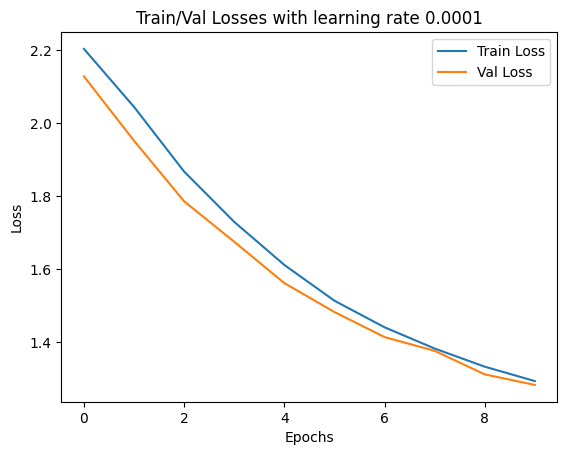

train_losses=[2.2026078263236655, 2.0439682145758464, 1.867134205013653, 1.729587683495419, 1.6118642191526111, 1.514019364490524, 1.4413986120460185, 1.3832830924046764, 1.3336530044651627, 1.2943147630220084]
[2.127399790755526, 1.9514161812512982, 1.785814745587553, 1.6752422418136264, 1.5621930251475504, 1.483075548164015, 1.4145696179878937, 1.3769995671909796, 1.3126455764496343, 1.2837883805126775]
Params lr=0.0001, w=0.01, opt=Adam


100%|██████████| 1374/1374 [00:07<00:00, 191.83it/s]


Epoch [1/10], Train Loss: 2.2389, Accuracy: 18.87%, Val Loss: 2.2110, Accuracy: 18.81%


100%|██████████| 1374/1374 [00:05<00:00, 250.64it/s]


Epoch [2/10], Train Loss: 2.1606, Accuracy: 21.04%, Val Loss: 2.0968, Accuracy: 25.53%


100%|██████████| 1374/1374 [00:08<00:00, 166.82it/s]


Epoch [3/10], Train Loss: 2.0376, Accuracy: 26.39%, Val Loss: 1.9732, Accuracy: 30.48%


100%|██████████| 1374/1374 [00:05<00:00, 246.81it/s]


Epoch [4/10], Train Loss: 1.9211, Accuracy: 31.90%, Val Loss: 1.8793, Accuracy: 36.09%


100%|██████████| 1374/1374 [00:08<00:00, 160.47it/s]


Epoch [5/10], Train Loss: 1.8401, Accuracy: 36.70%, Val Loss: 1.7980, Accuracy: 40.80%


100%|██████████| 1374/1374 [00:05<00:00, 252.74it/s]


Epoch [6/10], Train Loss: 1.7805, Accuracy: 39.91%, Val Loss: 1.7690, Accuracy: 41.76%


100%|██████████| 1374/1374 [00:08<00:00, 162.06it/s]


Epoch [7/10], Train Loss: 1.7299, Accuracy: 42.22%, Val Loss: 1.7323, Accuracy: 42.07%


100%|██████████| 1374/1374 [00:05<00:00, 252.95it/s]


Epoch [8/10], Train Loss: 1.6828, Accuracy: 44.25%, Val Loss: 1.6666, Accuracy: 46.61%


100%|██████████| 1374/1374 [00:08<00:00, 159.79it/s]


Epoch [9/10], Train Loss: 1.6383, Accuracy: 46.04%, Val Loss: 1.6154, Accuracy: 46.98%


100%|██████████| 1374/1374 [00:05<00:00, 250.13it/s]


Epoch [10/10], Train Loss: 1.5937, Accuracy: 47.99%, Val Loss: 1.5625, Accuracy: 49.69%


100%|██████████| 1374/1374 [00:06<00:00, 212.70it/s]


Test Accuracy: 49.46%


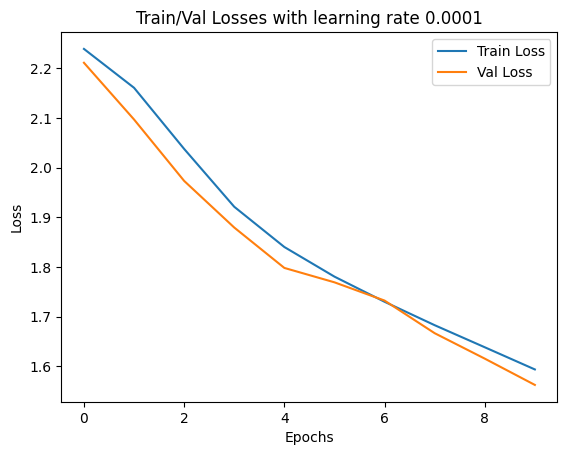

train_losses=[2.2388534397119293, 2.1606123228340923, 2.037553079656431, 1.921113240523569, 1.840111844848359, 1.780500502733284, 1.7298811606330544, 1.6827503546072802, 1.6383179052757584, 1.5936739837974543]
[2.210982052693374, 2.096799970193721, 1.9731742370076575, 1.8793050493215369, 1.7980113023406727, 1.7690368328118775, 1.7323220589101922, 1.6666441336816402, 1.6154287970656043, 1.5625085637211973]
Params lr=0.001, w=0.0001, opt=Adam


100%|██████████| 1374/1374 [00:05<00:00, 258.58it/s]


Epoch [1/10], Train Loss: 2.2406, Accuracy: 18.87%, Val Loss: 2.2097, Accuracy: 18.81%


100%|██████████| 1374/1374 [00:08<00:00, 164.83it/s]


Epoch [2/10], Train Loss: 2.1884, Accuracy: 18.92%, Val Loss: 2.1676, Accuracy: 19.81%


100%|██████████| 1374/1374 [00:05<00:00, 247.47it/s]


Epoch [3/10], Train Loss: 2.1688, Accuracy: 19.65%, Val Loss: 2.1693, Accuracy: 19.36%


100%|██████████| 1374/1374 [00:08<00:00, 162.17it/s]


Epoch [4/10], Train Loss: 2.1652, Accuracy: 19.56%, Val Loss: 2.1584, Accuracy: 19.77%


100%|██████████| 1374/1374 [00:05<00:00, 243.65it/s]


Epoch [5/10], Train Loss: 2.1640, Accuracy: 19.66%, Val Loss: 2.1516, Accuracy: 19.98%


100%|██████████| 1374/1374 [00:06<00:00, 205.04it/s]


Epoch [6/10], Train Loss: 2.1622, Accuracy: 19.54%, Val Loss: 2.1534, Accuracy: 19.81%


100%|██████████| 1374/1374 [00:05<00:00, 254.98it/s]


Epoch [7/10], Train Loss: 2.1623, Accuracy: 19.51%, Val Loss: 2.1498, Accuracy: 20.17%


100%|██████████| 1374/1374 [00:07<00:00, 186.94it/s]


Epoch [8/10], Train Loss: 2.1608, Accuracy: 19.69%, Val Loss: 2.1483, Accuracy: 20.24%


100%|██████████| 1374/1374 [00:05<00:00, 254.96it/s]


Epoch [9/10], Train Loss: 2.1620, Accuracy: 19.65%, Val Loss: 2.1494, Accuracy: 20.18%


100%|██████████| 1374/1374 [00:07<00:00, 188.23it/s]


Epoch [10/10], Train Loss: 2.1607, Accuracy: 19.63%, Val Loss: 2.1594, Accuracy: 19.63%


100%|██████████| 1374/1374 [00:05<00:00, 249.98it/s]


Test Accuracy: 19.74%


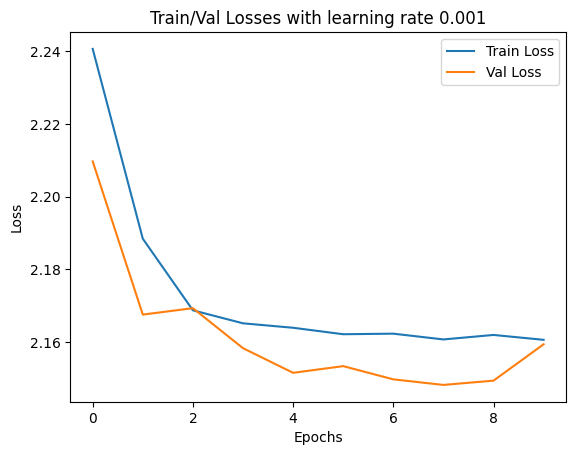

train_losses=[2.2405897546112072, 2.1884353880019343, 2.1687622781104863, 2.165189010583666, 2.1639651439119243, 2.162190163581866, 2.1623452380741255, 2.160759560477901, 2.1619947791285523, 2.1606529865175625]
[2.2096758222822888, 2.1675893968890327, 2.1693484706823134, 2.158357799053192, 2.151588608257288, 2.1534223330940567, 2.1497919982871285, 2.148260913648286, 2.1494335077562012, 2.1594278261477595]
Params lr=0.001, w=0.01, opt=Adam


100%|██████████| 1374/1374 [00:07<00:00, 186.41it/s]


Epoch [1/10], Train Loss: 2.2645, Accuracy: 18.15%, Val Loss: 2.2371, Accuracy: 18.81%


100%|██████████| 1374/1374 [00:05<00:00, 256.37it/s]


Epoch [2/10], Train Loss: 2.2601, Accuracy: 18.02%, Val Loss: 2.2694, Accuracy: 18.81%


100%|██████████| 1374/1374 [00:08<00:00, 166.27it/s]


Epoch [3/10], Train Loss: 2.2588, Accuracy: 18.17%, Val Loss: 2.2402, Accuracy: 18.81%


100%|██████████| 1374/1374 [00:05<00:00, 249.54it/s]


Epoch [4/10], Train Loss: 2.2590, Accuracy: 18.14%, Val Loss: 2.2436, Accuracy: 18.02%


100%|██████████| 1374/1374 [00:08<00:00, 158.91it/s]


Epoch [5/10], Train Loss: 2.2592, Accuracy: 18.16%, Val Loss: 2.2370, Accuracy: 18.81%


100%|██████████| 1374/1374 [00:05<00:00, 244.16it/s]


Epoch [6/10], Train Loss: 2.2581, Accuracy: 18.27%, Val Loss: 2.2659, Accuracy: 18.43%


100%|██████████| 1374/1374 [00:09<00:00, 149.97it/s]


Epoch [7/10], Train Loss: 2.2595, Accuracy: 18.26%, Val Loss: 2.3166, Accuracy: 14.98%


100%|██████████| 1374/1374 [00:08<00:00, 160.48it/s]


Epoch [8/10], Train Loss: 2.2596, Accuracy: 18.09%, Val Loss: 2.2370, Accuracy: 18.81%


100%|██████████| 1374/1374 [00:08<00:00, 155.13it/s]


Epoch [9/10], Train Loss: 2.2595, Accuracy: 18.30%, Val Loss: 2.3181, Accuracy: 16.13%


100%|██████████| 1374/1374 [00:05<00:00, 255.91it/s]


Epoch [10/10], Train Loss: 2.2580, Accuracy: 18.16%, Val Loss: 2.2456, Accuracy: 18.81%


100%|██████████| 1374/1374 [00:06<00:00, 197.09it/s]


Test Accuracy: 18.95%


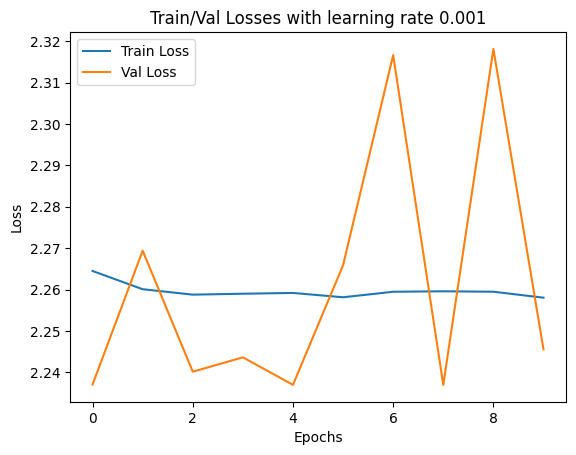

train_losses=[2.2644930641848284, 2.2600887071509814, 2.258781840239598, 2.2590030494978572, 2.2591919468085218, 2.258149539568867, 2.259478901738124, 2.259591127594994, 2.2594859017410815, 2.258046468129954]
[2.237082245568521, 2.2693966512596764, 2.2401712324247955, 2.2436474510502435, 2.2370024695667117, 2.2658950109495692, 2.3166126164633463, 2.2369852285544773, 2.318108316939297, 2.24557225534142]
Params lr=0.01, w=0.0001, opt=Adam


100%|██████████| 1374/1374 [00:05<00:00, 255.19it/s]


Epoch [1/10], Train Loss: 2.2889, Accuracy: 18.75%, Val Loss: 2.2386, Accuracy: 18.81%


100%|██████████| 1374/1374 [00:07<00:00, 174.97it/s]


Epoch [2/10], Train Loss: 2.3358, Accuracy: 18.70%, Val Loss: 2.2392, Accuracy: 18.81%


100%|██████████| 1374/1374 [00:05<00:00, 245.64it/s]


Epoch [3/10], Train Loss: 2.3796, Accuracy: 18.74%, Val Loss: 2.2372, Accuracy: 18.81%


100%|██████████| 1374/1374 [00:06<00:00, 202.11it/s]


Epoch [4/10], Train Loss: 2.3029, Accuracy: 18.80%, Val Loss: 2.2386, Accuracy: 18.81%


100%|██████████| 1374/1374 [00:05<00:00, 253.23it/s]


Epoch [5/10], Train Loss: 2.3234, Accuracy: 18.78%, Val Loss: 2.2363, Accuracy: 18.81%


100%|██████████| 1374/1374 [00:07<00:00, 177.65it/s]


Epoch [6/10], Train Loss: 2.3343, Accuracy: 18.78%, Val Loss: 2.2369, Accuracy: 18.81%


100%|██████████| 1374/1374 [00:05<00:00, 245.12it/s]


Epoch [7/10], Train Loss: 2.3112, Accuracy: 18.80%, Val Loss: 2.2364, Accuracy: 18.81%


100%|██████████| 1374/1374 [00:06<00:00, 223.56it/s]


Epoch [8/10], Train Loss: 2.3132, Accuracy: 18.77%, Val Loss: 2.2355, Accuracy: 18.81%


100%|██████████| 1374/1374 [00:05<00:00, 240.57it/s]


Epoch [9/10], Train Loss: 2.3357, Accuracy: 18.79%, Val Loss: 2.2383, Accuracy: 18.81%


100%|██████████| 1374/1374 [00:06<00:00, 198.10it/s]


Epoch [10/10], Train Loss: 2.3066, Accuracy: 18.83%, Val Loss: 2.2379, Accuracy: 18.81%


100%|██████████| 1374/1374 [00:05<00:00, 260.20it/s]


Test Accuracy: 18.95%


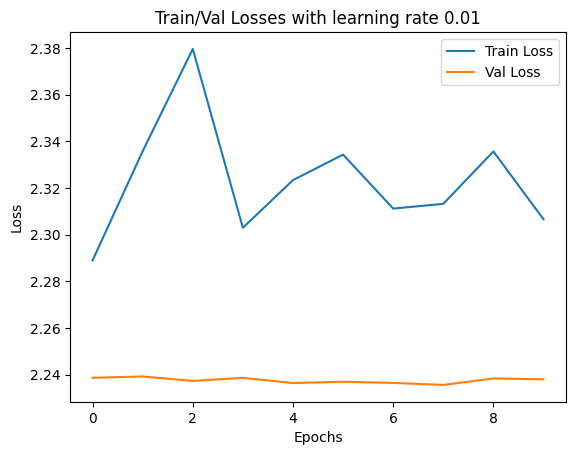

train_losses=[2.288934309173858, 2.335752375709843, 2.3796239237889485, 2.302926690418523, 2.3233685180103163, 2.3343062943861748, 2.311153918941754, 2.3131927517944493, 2.3356535258047666, 2.3065813854592454]
[2.238595060906556, 2.2391603544809935, 2.2372470533656936, 2.2385644394757964, 2.2363437919984563, 2.236899864465389, 2.236391657478077, 2.2355333488580964, 2.2382903864289996, 2.2379382463521833]
Params lr=0.01, w=0.01, opt=Adam


100%|██████████| 1374/1374 [00:06<00:00, 228.19it/s]


Epoch [1/10], Train Loss: 2.8005, Accuracy: 15.37%, Val Loss: 2.9848, Accuracy: 6.76%


100%|██████████| 1374/1374 [00:07<00:00, 172.57it/s]


Epoch [2/10], Train Loss: 2.7291, Accuracy: 16.02%, Val Loss: 2.2426, Accuracy: 18.81%


100%|██████████| 1374/1374 [00:05<00:00, 270.05it/s]


Epoch [3/10], Train Loss: 2.7063, Accuracy: 16.22%, Val Loss: 2.2618, Accuracy: 18.81%


100%|██████████| 1374/1374 [00:06<00:00, 215.32it/s]


Epoch [4/10], Train Loss: 2.6876, Accuracy: 15.93%, Val Loss: 2.3722, Accuracy: 12.72%


100%|██████████| 1374/1374 [00:05<00:00, 252.99it/s]


Epoch [5/10], Train Loss: 2.6861, Accuracy: 16.04%, Val Loss: 2.2749, Accuracy: 17.67%


100%|██████████| 1374/1374 [00:06<00:00, 220.40it/s]


Epoch [6/10], Train Loss: 2.6761, Accuracy: 16.26%, Val Loss: 2.6272, Accuracy: 11.67%


100%|██████████| 1374/1374 [00:08<00:00, 166.44it/s]


Epoch [7/10], Train Loss: 2.6921, Accuracy: 16.21%, Val Loss: 2.2388, Accuracy: 18.81%


100%|██████████| 1374/1374 [00:05<00:00, 252.92it/s]


Epoch [8/10], Train Loss: 2.7052, Accuracy: 16.35%, Val Loss: 2.2371, Accuracy: 18.81%


100%|██████████| 1374/1374 [00:05<00:00, 262.84it/s]


Epoch [9/10], Train Loss: 2.6985, Accuracy: 15.98%, Val Loss: 2.2548, Accuracy: 18.81%


100%|██████████| 1374/1374 [00:08<00:00, 168.94it/s]


Epoch [10/10], Train Loss: 2.7015, Accuracy: 16.31%, Val Loss: 2.2371, Accuracy: 18.81%


100%|██████████| 1374/1374 [00:05<00:00, 265.17it/s]


Test Accuracy: 18.95%


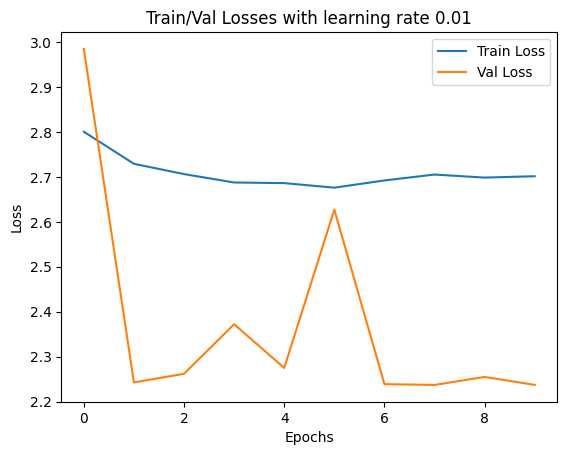

train_losses=[2.8005283635603657, 2.72911747868831, 2.706277061159637, 2.6875721878083003, 2.686146056168537, 2.6760527503099905, 2.692084117277922, 2.705236246265971, 2.698450554086712, 2.7014910173862474]
[2.984789421724961, 2.242589236954241, 2.2618459496088597, 2.3721794438327417, 2.2748781367160347, 2.6272489515280966, 2.2387997681570537, 2.2370916546866018, 2.2548305733235123, 2.2371278845066587]
Params lr=0.0001, w=0.0001, opt=RMSprop


100%|██████████| 1374/1374 [00:05<00:00, 263.58it/s]


Epoch [1/10], Train Loss: 2.2195, Accuracy: 19.66%, Val Loss: 2.1471, Accuracy: 21.62%


100%|██████████| 1374/1374 [00:05<00:00, 235.03it/s]


Epoch [2/10], Train Loss: 2.0016, Accuracy: 30.17%, Val Loss: 1.8470, Accuracy: 38.70%


100%|██████████| 1374/1374 [00:08<00:00, 164.71it/s]


Epoch [3/10], Train Loss: 1.7409, Accuracy: 41.39%, Val Loss: 1.6525, Accuracy: 44.51%


100%|██████████| 1374/1374 [00:05<00:00, 248.05it/s]


Epoch [4/10], Train Loss: 1.5947, Accuracy: 46.66%, Val Loss: 1.5620, Accuracy: 48.80%


100%|██████████| 1374/1374 [00:08<00:00, 167.39it/s]


Epoch [5/10], Train Loss: 1.4941, Accuracy: 51.63%, Val Loss: 1.4570, Accuracy: 52.93%


100%|██████████| 1374/1374 [00:05<00:00, 246.07it/s]


Epoch [6/10], Train Loss: 1.4134, Accuracy: 55.22%, Val Loss: 1.3790, Accuracy: 57.08%


100%|██████████| 1374/1374 [00:08<00:00, 170.62it/s]


Epoch [7/10], Train Loss: 1.3439, Accuracy: 58.20%, Val Loss: 1.3205, Accuracy: 59.59%


100%|██████████| 1374/1374 [00:05<00:00, 246.20it/s]


Epoch [8/10], Train Loss: 1.2864, Accuracy: 60.41%, Val Loss: 1.2648, Accuracy: 61.41%


100%|██████████| 1374/1374 [00:06<00:00, 215.63it/s]


Epoch [9/10], Train Loss: 1.2409, Accuracy: 62.05%, Val Loss: 1.2528, Accuracy: 62.29%


100%|██████████| 1374/1374 [00:08<00:00, 153.57it/s]


Epoch [10/10], Train Loss: 1.2032, Accuracy: 63.31%, Val Loss: 1.2003, Accuracy: 63.55%


100%|██████████| 1374/1374 [00:05<00:00, 260.01it/s]


Test Accuracy: 63.57%


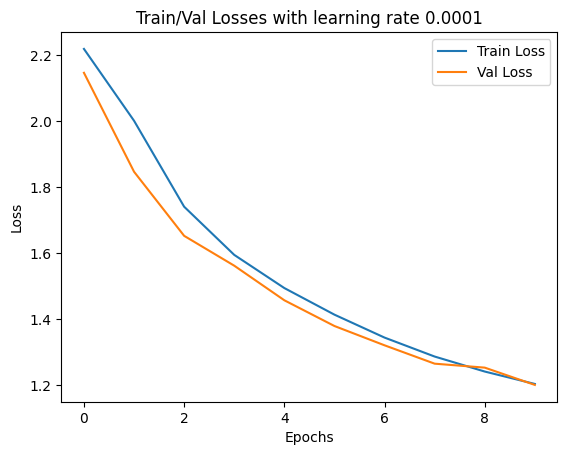

train_losses=[2.219525250945932, 2.001570317265396, 1.740882106374095, 1.5947341270035775, 1.4941031777728553, 1.4134372900596088, 1.3438719509986001, 1.2863801234597907, 1.2408853039447678, 1.2032203421554588]
[2.1470797062787774, 1.8469606654439257, 1.6525326606314603, 1.56198292363332, 1.4570332259113266, 1.3789912987570923, 1.3204562695265858, 1.2647679202160982, 1.2527535402228218, 1.200305318424622]
Params lr=0.0001, w=0.01, opt=RMSprop


100%|██████████| 1374/1374 [00:05<00:00, 246.20it/s]


Epoch [1/10], Train Loss: 2.2261, Accuracy: 18.95%, Val Loss: 2.1736, Accuracy: 18.96%


100%|██████████| 1374/1374 [00:08<00:00, 168.48it/s]


Epoch [2/10], Train Loss: 2.0943, Accuracy: 22.86%, Val Loss: 1.9992, Accuracy: 26.54%


100%|██████████| 1374/1374 [00:05<00:00, 246.69it/s]


Epoch [3/10], Train Loss: 1.9265, Accuracy: 32.51%, Val Loss: 1.8641, Accuracy: 35.29%


100%|██████████| 1374/1374 [00:08<00:00, 157.03it/s]


Epoch [4/10], Train Loss: 1.8209, Accuracy: 37.85%, Val Loss: 1.8019, Accuracy: 40.47%


100%|██████████| 1374/1374 [00:05<00:00, 254.97it/s]


Epoch [5/10], Train Loss: 1.7530, Accuracy: 41.33%, Val Loss: 1.7277, Accuracy: 44.29%


100%|██████████| 1374/1374 [00:06<00:00, 220.40it/s]


Epoch [6/10], Train Loss: 1.7010, Accuracy: 44.02%, Val Loss: 1.6813, Accuracy: 44.14%


100%|██████████| 1374/1374 [00:08<00:00, 162.46it/s]


Epoch [7/10], Train Loss: 1.6547, Accuracy: 46.36%, Val Loss: 1.6302, Accuracy: 46.85%


100%|██████████| 1374/1374 [00:05<00:00, 239.88it/s]


Epoch [8/10], Train Loss: 1.6098, Accuracy: 48.15%, Val Loss: 1.6036, Accuracy: 48.50%


100%|██████████| 1374/1374 [00:05<00:00, 254.34it/s]


Epoch [9/10], Train Loss: 1.5699, Accuracy: 49.70%, Val Loss: 1.5511, Accuracy: 51.03%


100%|██████████| 1374/1374 [00:08<00:00, 158.41it/s]


Epoch [10/10], Train Loss: 1.5316, Accuracy: 51.14%, Val Loss: 1.4898, Accuracy: 53.53%


100%|██████████| 1374/1374 [00:05<00:00, 259.29it/s]


Test Accuracy: 53.68%


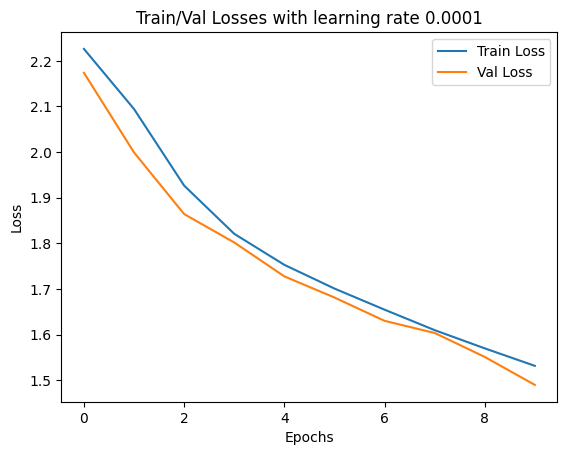

train_losses=[2.2260616746038058, 2.0942724187362955, 1.9265067377812033, 1.820911490182609, 1.7529505208297378, 1.7009751129540935, 1.6547203667915185, 1.6098465113390628, 1.5699200784825311, 1.5316164688368483]
[2.1736090316002024, 1.9991654103846876, 1.8641478127787727, 1.8019110644575116, 1.727677343931087, 1.6813231205575851, 1.6302402339214148, 1.6036358856564874, 1.551138948491914, 1.489818875272548]
Params lr=0.001, w=0.0001, opt=RMSprop


100%|██████████| 1374/1374 [00:05<00:00, 230.48it/s]


Epoch [1/10], Train Loss: 2.0912, Accuracy: 24.72%, Val Loss: 1.9431, Accuracy: 28.85%


100%|██████████| 1374/1374 [00:09<00:00, 140.12it/s]


Epoch [2/10], Train Loss: 1.9273, Accuracy: 30.22%, Val Loss: 1.8635, Accuracy: 32.47%


100%|██████████| 1374/1374 [00:05<00:00, 238.94it/s]


Epoch [3/10], Train Loss: 1.8984, Accuracy: 31.19%, Val Loss: 1.8790, Accuracy: 31.60%


100%|██████████| 1374/1374 [00:06<00:00, 219.02it/s]


Epoch [4/10], Train Loss: 1.8732, Accuracy: 32.48%, Val Loss: 1.8538, Accuracy: 32.73%


100%|██████████| 1374/1374 [00:08<00:00, 168.98it/s]


Epoch [5/10], Train Loss: 1.8549, Accuracy: 33.48%, Val Loss: 1.8363, Accuracy: 34.01%


100%|██████████| 1374/1374 [00:05<00:00, 250.69it/s]


Epoch [6/10], Train Loss: 1.8387, Accuracy: 34.50%, Val Loss: 1.8672, Accuracy: 34.25%


100%|██████████| 1374/1374 [00:07<00:00, 179.31it/s]


Epoch [7/10], Train Loss: 1.8273, Accuracy: 35.21%, Val Loss: 1.8173, Accuracy: 35.64%


100%|██████████| 1374/1374 [00:05<00:00, 237.69it/s]


Epoch [8/10], Train Loss: 1.8202, Accuracy: 35.50%, Val Loss: 1.8023, Accuracy: 36.72%


100%|██████████| 1374/1374 [00:05<00:00, 251.74it/s]


Epoch [9/10], Train Loss: 1.8149, Accuracy: 35.73%, Val Loss: 1.8226, Accuracy: 35.87%


100%|██████████| 1374/1374 [00:09<00:00, 152.17it/s]


Epoch [10/10], Train Loss: 1.8091, Accuracy: 36.06%, Val Loss: 1.8941, Accuracy: 35.70%


100%|██████████| 1374/1374 [00:05<00:00, 259.28it/s]


Test Accuracy: 35.23%


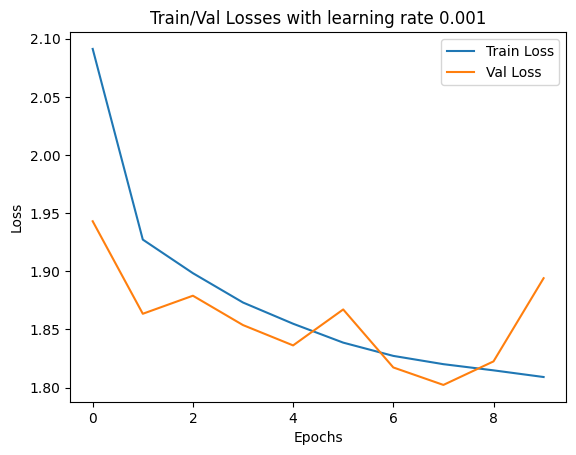

train_losses=[2.0912258273911735, 1.9272910229036477, 1.8983979671775086, 1.8731806359592353, 1.854940075444729, 1.8386897355643523, 1.8272850863182228, 1.8201662922705206, 1.8148621645620944, 1.8091195062709486]
[1.9430544267054728, 1.8635044585495883, 1.87902864969974, 1.8537807716205825, 1.8363029372483883, 1.867212181441822, 1.817344300611571, 1.802325475814561, 1.8225534622932973, 1.8940862619807453]
Params lr=0.001, w=0.01, opt=RMSprop


100%|██████████| 1374/1374 [00:05<00:00, 234.65it/s]


Epoch [1/10], Train Loss: 2.2612, Accuracy: 18.89%, Val Loss: 2.2370, Accuracy: 18.81%


100%|██████████| 1374/1374 [00:09<00:00, 145.46it/s]


Epoch [2/10], Train Loss: 2.2382, Accuracy: 18.94%, Val Loss: 2.2358, Accuracy: 18.81%


100%|██████████| 1374/1374 [00:05<00:00, 244.33it/s]


Epoch [3/10], Train Loss: 2.2381, Accuracy: 18.94%, Val Loss: 2.2357, Accuracy: 18.81%


100%|██████████| 1374/1374 [00:09<00:00, 147.58it/s]


Epoch [4/10], Train Loss: 2.2382, Accuracy: 18.94%, Val Loss: 2.2356, Accuracy: 18.81%


100%|██████████| 1374/1374 [00:06<00:00, 220.30it/s]


Epoch [5/10], Train Loss: 2.2382, Accuracy: 18.94%, Val Loss: 2.2353, Accuracy: 18.81%


100%|██████████| 1374/1374 [00:07<00:00, 182.47it/s]


Epoch [6/10], Train Loss: 2.2380, Accuracy: 18.94%, Val Loss: 2.2361, Accuracy: 18.81%


100%|██████████| 1374/1374 [00:06<00:00, 203.12it/s]


Epoch [7/10], Train Loss: 2.2382, Accuracy: 18.94%, Val Loss: 2.2361, Accuracy: 18.81%


100%|██████████| 1374/1374 [00:07<00:00, 177.71it/s]


Epoch [8/10], Train Loss: 2.2382, Accuracy: 18.94%, Val Loss: 2.2354, Accuracy: 18.81%


100%|██████████| 1374/1374 [00:06<00:00, 216.59it/s]


Epoch [9/10], Train Loss: 2.2380, Accuracy: 18.94%, Val Loss: 2.2361, Accuracy: 18.81%


100%|██████████| 1374/1374 [00:09<00:00, 145.74it/s]


Epoch [10/10], Train Loss: 2.2381, Accuracy: 18.94%, Val Loss: 2.2358, Accuracy: 18.81%


100%|██████████| 1374/1374 [00:05<00:00, 245.39it/s]


Test Accuracy: 18.95%


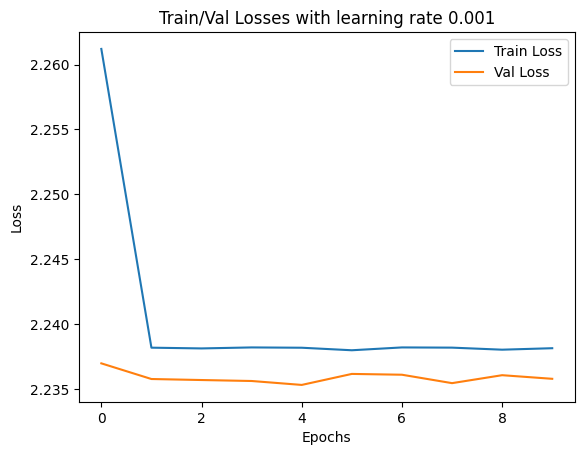

train_losses=[2.2612083359739152, 2.2381726160064317, 2.238114999776325, 2.2381919405761637, 2.2381685473431663, 2.237973669110892, 2.2381917918528114, 2.238175860898171, 2.2380177756553508, 2.2381314169412097]
[2.236964209978584, 2.2357566934485624, 2.2356781543082023, 2.235603507082188, 2.235300966051815, 2.2361492289032303, 2.2360871245073266, 2.2354378788752327, 2.2360507980357784, 2.235772394023434]
Params lr=0.01, w=0.0001, opt=RMSprop


100%|██████████| 1374/1374 [00:06<00:00, 197.42it/s]


Epoch [1/10], Train Loss: 2.8401, Accuracy: 18.81%, Val Loss: 2.2373, Accuracy: 18.81%


100%|██████████| 1374/1374 [00:05<00:00, 230.50it/s]


Epoch [2/10], Train Loss: 2.2409, Accuracy: 18.94%, Val Loss: 2.2371, Accuracy: 18.81%


100%|██████████| 1374/1374 [00:06<00:00, 224.68it/s]


Epoch [3/10], Train Loss: 2.2402, Accuracy: 18.92%, Val Loss: 2.2365, Accuracy: 18.81%


100%|██████████| 1374/1374 [00:10<00:00, 137.31it/s]


Epoch [4/10], Train Loss: 2.2403, Accuracy: 18.90%, Val Loss: 2.2388, Accuracy: 18.81%


100%|██████████| 1374/1374 [00:06<00:00, 220.53it/s]


Epoch [5/10], Train Loss: 2.2402, Accuracy: 18.94%, Val Loss: 2.2378, Accuracy: 18.81%


100%|██████████| 1374/1374 [00:07<00:00, 183.02it/s]


Epoch [6/10], Train Loss: 2.2401, Accuracy: 18.94%, Val Loss: 2.2349, Accuracy: 18.81%


100%|██████████| 1374/1374 [00:08<00:00, 155.22it/s]


Epoch [7/10], Train Loss: 2.2400, Accuracy: 18.93%, Val Loss: 2.2375, Accuracy: 18.81%


100%|██████████| 1374/1374 [00:05<00:00, 243.71it/s]


Epoch [8/10], Train Loss: 2.2401, Accuracy: 18.93%, Val Loss: 2.2375, Accuracy: 18.81%


100%|██████████| 1374/1374 [00:06<00:00, 201.39it/s]


Epoch [9/10], Train Loss: 2.2400, Accuracy: 18.94%, Val Loss: 2.2355, Accuracy: 18.81%


100%|██████████| 1374/1374 [00:05<00:00, 237.52it/s]


Epoch [10/10], Train Loss: 2.2399, Accuracy: 18.94%, Val Loss: 2.2361, Accuracy: 18.81%


100%|██████████| 1374/1374 [00:06<00:00, 228.60it/s]


Test Accuracy: 18.95%


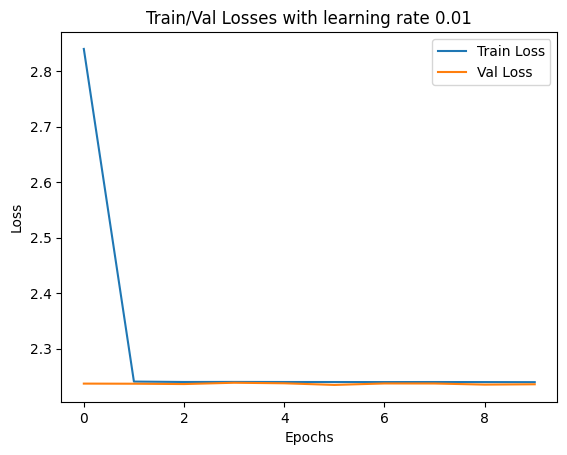

train_losses=[2.840098945622139, 2.2409300921115785, 2.240193226408103, 2.2403091527184533, 2.2401658571082605, 2.240123486611847, 2.240044080932129, 2.240124615287632, 2.2400303970261035, 2.239892238276239]
[2.2372699689656885, 2.2370644927545404, 2.236463114944608, 2.2388171347121135, 2.237849806160212, 2.234904129085235, 2.2375423504796093, 2.237462689349051, 2.2354585449421425, 2.236060119091684]
Params lr=0.01, w=0.01, opt=RMSprop


100%|██████████| 1374/1374 [00:05<00:00, 245.22it/s]


Epoch [1/10], Train Loss: 2.7824, Accuracy: 18.85%, Val Loss: 2.2406, Accuracy: 18.81%


100%|██████████| 1374/1374 [00:06<00:00, 223.41it/s]


Epoch [2/10], Train Loss: 2.2400, Accuracy: 18.93%, Val Loss: 2.2379, Accuracy: 18.81%


100%|██████████| 1374/1374 [00:08<00:00, 168.11it/s]


Epoch [3/10], Train Loss: 2.2401, Accuracy: 18.93%, Val Loss: 2.2363, Accuracy: 18.81%


100%|██████████| 1374/1374 [00:05<00:00, 232.59it/s]


Epoch [4/10], Train Loss: 2.2403, Accuracy: 18.90%, Val Loss: 2.2365, Accuracy: 18.81%


100%|██████████| 1374/1374 [00:05<00:00, 245.09it/s]


Epoch [5/10], Train Loss: 2.2407, Accuracy: 18.94%, Val Loss: 2.2381, Accuracy: 18.81%


100%|██████████| 1374/1374 [00:08<00:00, 153.48it/s]


Epoch [6/10], Train Loss: 2.2401, Accuracy: 18.88%, Val Loss: 2.2397, Accuracy: 18.81%


100%|██████████| 1374/1374 [00:05<00:00, 239.43it/s]


Epoch [7/10], Train Loss: 2.2399, Accuracy: 18.94%, Val Loss: 2.2446, Accuracy: 18.81%


100%|██████████| 1374/1374 [00:06<00:00, 198.88it/s]


Epoch [8/10], Train Loss: 2.2405, Accuracy: 18.90%, Val Loss: 2.2361, Accuracy: 18.81%


100%|██████████| 1374/1374 [00:05<00:00, 238.33it/s]


Epoch [9/10], Train Loss: 2.2405, Accuracy: 18.94%, Val Loss: 2.2388, Accuracy: 18.81%


100%|██████████| 1374/1374 [00:06<00:00, 203.03it/s]


Epoch [10/10], Train Loss: 2.2402, Accuracy: 18.93%, Val Loss: 2.2378, Accuracy: 18.81%


100%|██████████| 1374/1374 [00:07<00:00, 189.76it/s]


Test Accuracy: 18.95%


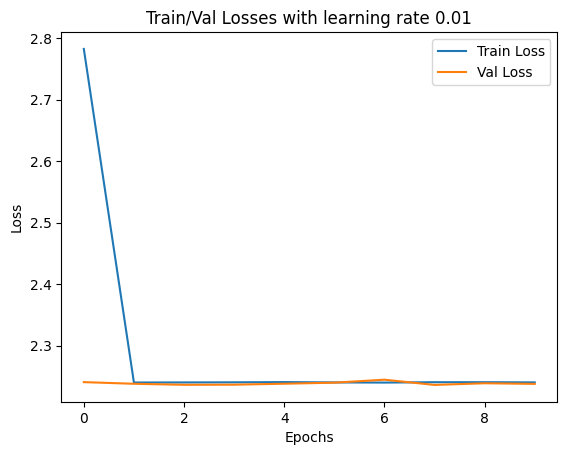

train_losses=[2.7823970475360493, 2.2399907780883836, 2.240118164354107, 2.24031063985899, 2.2406780993510704, 2.2401397854973113, 2.239889545169152, 2.2404951838732883, 2.2404944229423536, 2.240193237064409]
[2.240619435667818, 2.2379456750690676, 2.2362711019217536, 2.2364565710139934, 2.238058738052585, 2.2397175563995493, 2.2445648866969945, 2.236078385616147, 2.2387835028563696, 2.2377586959057325]


In [ ]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from torch.optim import SGD, Adam, RMSprop

NUM_CLASSES = 10

def create_model(input_size, hidden_size, output_size):
    return AircraftNet(input_size=input_size, hidden_size=hidden_size, output_size=output_size).to(device)

def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images = images.view(-1, IMAGE_HEIGHT*IMAGE_WIDTH*3).to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

num_epochs = 10
weight_decay_list = [0.0001, 0.01]
learning_rates = [0.0001, 0.001, 0.01]
optimizers = [SGD, Adam, RMSprop]
results = pd.DataFrame(columns=['opt', 'best_acc', 'lr', 'weight_decay'])

for opt in optimizers:
    for lr in learning_rates:
        for w in weight_decay_list:
            model = create_model(IMAGE_HEIGHT*IMAGE_WIDTH*3, 256, NUM_CLASSES)
            print(f"Params lr={lr}, w={w}, opt={opt.__name__}")
            train_losses, val_losses, results = train_model(model, opt, train_data_loader, val_data_loader, num_epochs, lr, weight_decay=w, results_df=results_df)
            accuracy = test_model(model, test_data_loader)
            print(f"Test Accuracy: {100 * accuracy:.2f}%")
            plt.plot(range(num_epochs), train_losses, label='Train Loss')
            plt.plot(range(num_epochs), val_losses, label='Val Loss')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.title(f'Train/Val Losses with learning rate {lr}')
            plt.legend()
            plt.show()
            print(f"{train_losses=}\n{val_losses}")


Params lr=0.0001, w=0.01, opt=RMSprop


  0%|          | 0/6410 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1374/1374 [00:04<00:00, 302.96it/s]


Epoch [1/50], Train Loss: 1.8676, Accuracy: 37.32%, Val Loss: 1.6922, Accuracy: 44.53%


100%|██████████| 1374/1374 [00:04<00:00, 307.51it/s]


Epoch [2/50], Train Loss: 1.6425, Accuracy: 46.82%, Val Loss: 1.4640, Accuracy: 52.87%


100%|██████████| 1374/1374 [00:04<00:00, 301.21it/s]


Epoch [3/50], Train Loss: 1.5830, Accuracy: 49.11%, Val Loss: 1.6651, Accuracy: 44.26%


100%|██████████| 1374/1374 [00:06<00:00, 225.86it/s]


Epoch [4/50], Train Loss: 1.5397, Accuracy: 51.02%, Val Loss: 1.4425, Accuracy: 54.66%


100%|██████████| 1374/1374 [00:07<00:00, 193.83it/s]


Epoch [5/50], Train Loss: 1.5049, Accuracy: 51.89%, Val Loss: 1.2762, Accuracy: 62.28%


100%|██████████| 1374/1374 [00:04<00:00, 279.12it/s]


Epoch [6/50], Train Loss: 1.4770, Accuracy: 52.88%, Val Loss: 1.3465, Accuracy: 57.24%


100%|██████████| 1374/1374 [00:04<00:00, 298.62it/s]


Epoch [7/50], Train Loss: 1.4522, Accuracy: 54.02%, Val Loss: 1.2447, Accuracy: 61.86%


100%|██████████| 1374/1374 [00:04<00:00, 307.99it/s]


Epoch [8/50], Train Loss: 1.4445, Accuracy: 54.04%, Val Loss: 1.6913, Accuracy: 43.79%


100%|██████████| 1374/1374 [00:05<00:00, 251.58it/s]


Epoch [9/50], Train Loss: 1.4265, Accuracy: 54.58%, Val Loss: 1.2839, Accuracy: 59.17%


100%|██████████| 1374/1374 [00:04<00:00, 282.71it/s]


Epoch [10/50], Train Loss: 1.4223, Accuracy: 54.81%, Val Loss: 1.3147, Accuracy: 58.79%


100%|██████████| 1374/1374 [00:05<00:00, 264.54it/s]


Epoch [11/50], Train Loss: 1.4082, Accuracy: 55.07%, Val Loss: 1.2186, Accuracy: 65.97%


100%|██████████| 1374/1374 [00:06<00:00, 220.38it/s]


Epoch [12/50], Train Loss: 1.4162, Accuracy: 54.82%, Val Loss: 1.3428, Accuracy: 57.22%


100%|██████████| 1374/1374 [00:04<00:00, 300.69it/s]


Epoch [13/50], Train Loss: 1.3998, Accuracy: 55.54%, Val Loss: 1.2132, Accuracy: 60.36%


100%|██████████| 1374/1374 [00:04<00:00, 306.36it/s]


Epoch [14/50], Train Loss: 1.3984, Accuracy: 55.63%, Val Loss: 1.1371, Accuracy: 65.78%


100%|██████████| 1374/1374 [00:04<00:00, 298.39it/s]


Epoch [15/50], Train Loss: 1.3901, Accuracy: 55.71%, Val Loss: 1.7741, Accuracy: 41.40%


100%|██████████| 1374/1374 [00:05<00:00, 232.89it/s]


Epoch [16/50], Train Loss: 1.3908, Accuracy: 55.81%, Val Loss: 1.5650, Accuracy: 51.30%


100%|██████████| 1374/1374 [00:04<00:00, 281.53it/s]


Epoch [17/50], Train Loss: 1.3898, Accuracy: 55.70%, Val Loss: 1.1946, Accuracy: 65.57%


100%|██████████| 1374/1374 [00:04<00:00, 304.17it/s]


Epoch [18/50], Train Loss: 1.3892, Accuracy: 55.76%, Val Loss: 1.5712, Accuracy: 51.52%


100%|██████████| 1374/1374 [00:04<00:00, 301.27it/s]


Epoch [19/50], Train Loss: 1.3905, Accuracy: 56.02%, Val Loss: 1.2076, Accuracy: 63.23%


100%|██████████| 1374/1374 [00:06<00:00, 202.54it/s]


Epoch [20/50], Train Loss: 1.3900, Accuracy: 55.70%, Val Loss: 1.2055, Accuracy: 62.92%


100%|██████████| 1374/1374 [00:04<00:00, 287.80it/s]


Epoch [21/50], Train Loss: 1.3886, Accuracy: 55.68%, Val Loss: 1.2746, Accuracy: 60.72%


100%|██████████| 1374/1374 [00:04<00:00, 304.34it/s]


Epoch [22/50], Train Loss: 1.3898, Accuracy: 56.03%, Val Loss: 1.1697, Accuracy: 64.17%


100%|██████████| 1374/1374 [00:05<00:00, 274.73it/s]


Epoch [23/50], Train Loss: 1.3865, Accuracy: 55.63%, Val Loss: 1.2987, Accuracy: 60.48%


100%|██████████| 1374/1374 [00:07<00:00, 181.15it/s]


Epoch [24/50], Train Loss: 1.3850, Accuracy: 55.83%, Val Loss: 1.1930, Accuracy: 60.58%


100%|██████████| 1374/1374 [00:04<00:00, 296.66it/s]


Epoch [25/50], Train Loss: 1.3860, Accuracy: 55.91%, Val Loss: 1.1177, Accuracy: 68.32%


100%|██████████| 1374/1374 [00:04<00:00, 303.77it/s]


Epoch [26/50], Train Loss: 1.3887, Accuracy: 55.88%, Val Loss: 1.1696, Accuracy: 64.70%


100%|██████████| 1374/1374 [00:04<00:00, 286.92it/s]


Epoch [27/50], Train Loss: 1.3895, Accuracy: 55.50%, Val Loss: 1.1462, Accuracy: 67.29%


100%|██████████| 1374/1374 [00:06<00:00, 217.52it/s]


Epoch [28/50], Train Loss: 1.3770, Accuracy: 56.18%, Val Loss: 1.1831, Accuracy: 63.16%


100%|██████████| 1374/1374 [00:04<00:00, 286.73it/s]


Epoch [29/50], Train Loss: 1.3878, Accuracy: 55.63%, Val Loss: 1.1989, Accuracy: 63.70%


100%|██████████| 1374/1374 [00:04<00:00, 293.25it/s]


Epoch [30/50], Train Loss: 1.3808, Accuracy: 56.25%, Val Loss: 1.2145, Accuracy: 62.36%


100%|██████████| 1374/1374 [00:05<00:00, 237.09it/s]


Epoch [31/50], Train Loss: 1.3814, Accuracy: 56.32%, Val Loss: 1.7967, Accuracy: 44.43%


100%|██████████| 1374/1374 [00:04<00:00, 302.31it/s]


Epoch [32/50], Train Loss: 1.3865, Accuracy: 55.87%, Val Loss: 1.3696, Accuracy: 55.57%


100%|██████████| 1374/1374 [00:04<00:00, 307.69it/s]


Epoch [33/50], Train Loss: 1.3806, Accuracy: 56.08%, Val Loss: 1.0540, Accuracy: 70.41%


100%|██████████| 1374/1374 [00:04<00:00, 294.95it/s]


Epoch [34/50], Train Loss: 1.3835, Accuracy: 55.74%, Val Loss: 1.2541, Accuracy: 60.17%


100%|██████████| 1374/1374 [00:06<00:00, 213.87it/s]


Epoch [35/50], Train Loss: 1.3826, Accuracy: 56.10%, Val Loss: 1.1807, Accuracy: 65.12%


100%|██████████| 1374/1374 [00:04<00:00, 302.10it/s]


Epoch [36/50], Train Loss: 1.3784, Accuracy: 56.21%, Val Loss: 1.2177, Accuracy: 63.79%


100%|██████████| 1374/1374 [00:04<00:00, 305.69it/s]


Epoch [37/50], Train Loss: 1.3787, Accuracy: 56.14%, Val Loss: 1.1187, Accuracy: 67.36%


100%|██████████| 1374/1374 [00:05<00:00, 248.68it/s]


Epoch [38/50], Train Loss: 1.3800, Accuracy: 56.01%, Val Loss: 1.1761, Accuracy: 65.80%


100%|██████████| 1374/1374 [00:04<00:00, 294.80it/s]


Epoch [39/50], Train Loss: 1.3844, Accuracy: 55.86%, Val Loss: 1.2476, Accuracy: 62.12%


100%|██████████| 1374/1374 [00:04<00:00, 308.61it/s]


Epoch [40/50], Train Loss: 1.3780, Accuracy: 56.15%, Val Loss: 1.4766, Accuracy: 54.23%


100%|██████████| 1374/1374 [00:04<00:00, 311.63it/s]


Epoch [41/50], Train Loss: 1.3816, Accuracy: 55.98%, Val Loss: 1.1835, Accuracy: 64.06%


100%|██████████| 1374/1374 [00:05<00:00, 261.28it/s]


Epoch [42/50], Train Loss: 1.3830, Accuracy: 55.94%, Val Loss: 1.1351, Accuracy: 67.83%


100%|██████████| 1374/1374 [00:06<00:00, 207.15it/s]


Epoch [43/50], Train Loss: 1.3829, Accuracy: 55.94%, Val Loss: 1.3643, Accuracy: 56.04%


100%|██████████| 1374/1374 [00:04<00:00, 308.94it/s]


Epoch [44/50], Train Loss: 1.3820, Accuracy: 55.81%, Val Loss: 1.1528, Accuracy: 64.53%


100%|██████████| 1374/1374 [00:05<00:00, 272.09it/s]


Epoch [45/50], Train Loss: 1.3750, Accuracy: 56.47%, Val Loss: 1.1392, Accuracy: 65.02%


100%|██████████| 1374/1374 [00:07<00:00, 184.37it/s]


Epoch [46/50], Train Loss: 1.3827, Accuracy: 56.04%, Val Loss: 1.1337, Accuracy: 67.66%


100%|██████████| 1374/1374 [00:04<00:00, 280.40it/s]


Epoch [47/50], Train Loss: 1.3768, Accuracy: 56.39%, Val Loss: 1.1237, Accuracy: 65.59%


100%|██████████| 1374/1374 [00:04<00:00, 291.48it/s]


Epoch [48/50], Train Loss: 1.3788, Accuracy: 56.38%, Val Loss: 1.7924, Accuracy: 46.41%


100%|██████████| 1374/1374 [00:05<00:00, 233.04it/s]


Epoch [49/50], Train Loss: 1.3745, Accuracy: 56.29%, Val Loss: 1.1559, Accuracy: 65.67%


100%|██████████| 1374/1374 [00:04<00:00, 290.90it/s]


Epoch [50/50], Train Loss: 1.3779, Accuracy: 56.37%, Val Loss: 1.1148, Accuracy: 66.63%


100%|██████████| 1374/1374 [00:04<00:00, 303.69it/s]


Test Accuracy: 66.74%


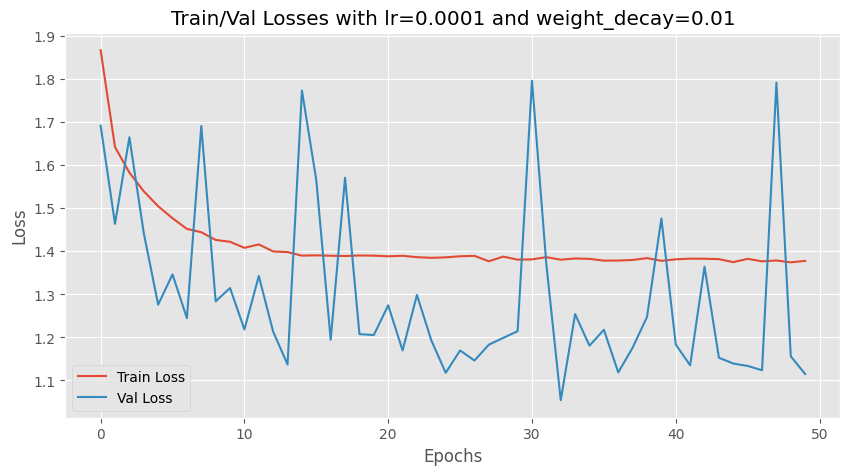

train_losses=[1.8675903363923387, 1.6424688665152711, 1.5830209445190877, 1.5397159441956865, 1.504942459928078, 1.476989610565248, 1.4522331883866404, 1.4445103149332235, 1.426548155077534, 1.422292841903505, 1.4082074956570325, 1.4161734155578285, 1.3998191296031435, 1.3983531021476723, 1.390077523219976, 1.390795124097845, 1.3898408535955105, 1.3892266121464847, 1.3904680065124901, 1.3900430799460448, 1.3886002076490436, 1.3897529191699303, 1.3864993255521503, 1.3850049435906402, 1.386029119619899, 1.3886893819814168, 1.3895353382165645, 1.3770184464183128, 1.387830893428017, 1.3807647260879392, 1.3813932508416182, 1.3865055185677295, 1.3806352542826612, 1.3835030001522783, 1.3826013136672528, 1.3784367510755422, 1.3787222679617253, 1.3800163056846715, 1.3843563113867214, 1.3780438946580367, 1.3815822843828365, 1.383046556495467, 1.3828795295423726, 1.3819837918147655, 1.3749609427174987, 1.3826658908271938, 1.3768238293492292, 1.378844433483579, 1.3745209713668423, 1.37791733097360

  0%|          | 0/6410 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1374/1374 [00:05<00:00, 236.78it/s]


Epoch [1/50], Train Loss: 2.1910, Accuracy: 22.86%, Val Loss: 1.8577, Accuracy: 38.38%


100%|██████████| 1374/1374 [00:04<00:00, 282.56it/s]


Epoch [2/50], Train Loss: 1.8855, Accuracy: 37.69%, Val Loss: 1.5891, Accuracy: 53.44%


100%|██████████| 1374/1374 [00:04<00:00, 286.97it/s]


Epoch [3/50], Train Loss: 1.7054, Accuracy: 44.56%, Val Loss: 1.3944, Accuracy: 60.82%


100%|██████████| 1374/1374 [00:04<00:00, 291.00it/s]


Epoch [4/50], Train Loss: 1.6129, Accuracy: 48.95%, Val Loss: 1.3174, Accuracy: 63.17%


100%|██████████| 1374/1374 [00:06<00:00, 215.79it/s]


Epoch [5/50], Train Loss: 1.5613, Accuracy: 50.94%, Val Loss: 1.2566, Accuracy: 65.68%


100%|██████████| 1374/1374 [00:07<00:00, 181.78it/s]


Epoch [6/50], Train Loss: 1.5215, Accuracy: 52.66%, Val Loss: 1.2575, Accuracy: 66.28%


100%|██████████| 1374/1374 [00:04<00:00, 286.56it/s]


Epoch [7/50], Train Loss: 1.4915, Accuracy: 53.84%, Val Loss: 1.2117, Accuracy: 67.59%


100%|██████████| 1374/1374 [00:05<00:00, 250.51it/s]


Epoch [8/50], Train Loss: 1.4568, Accuracy: 55.22%, Val Loss: 1.1605, Accuracy: 70.60%


100%|██████████| 1374/1374 [00:06<00:00, 223.04it/s]


Epoch [9/50], Train Loss: 1.4423, Accuracy: 55.58%, Val Loss: 1.1680, Accuracy: 69.86%


100%|██████████| 1374/1374 [00:04<00:00, 280.98it/s]


Epoch [10/50], Train Loss: 1.4181, Accuracy: 56.40%, Val Loss: 1.1057, Accuracy: 69.65%


100%|██████████| 1374/1374 [00:04<00:00, 287.80it/s]


Epoch [11/50], Train Loss: 1.4035, Accuracy: 57.06%, Val Loss: 1.1238, Accuracy: 70.37%


100%|██████████| 1374/1374 [00:04<00:00, 293.76it/s]


Epoch [12/50], Train Loss: 1.3803, Accuracy: 58.07%, Val Loss: 1.0444, Accuracy: 72.00%


100%|██████████| 1374/1374 [00:05<00:00, 239.20it/s]


Epoch [13/50], Train Loss: 1.3696, Accuracy: 58.20%, Val Loss: 1.1073, Accuracy: 68.54%


100%|██████████| 1374/1374 [00:07<00:00, 192.73it/s]


Epoch [14/50], Train Loss: 1.3558, Accuracy: 58.68%, Val Loss: 1.0326, Accuracy: 72.46%


100%|██████████| 1374/1374 [00:04<00:00, 287.06it/s]


Epoch [15/50], Train Loss: 1.3445, Accuracy: 58.93%, Val Loss: 1.0659, Accuracy: 72.47%


100%|██████████| 1374/1374 [00:04<00:00, 296.65it/s]


Epoch [16/50], Train Loss: 1.3367, Accuracy: 59.03%, Val Loss: 1.0469, Accuracy: 71.64%


100%|██████████| 1374/1374 [00:04<00:00, 286.56it/s]


Epoch [17/50], Train Loss: 1.3197, Accuracy: 59.73%, Val Loss: 1.0160, Accuracy: 72.95%


100%|██████████| 1374/1374 [00:05<00:00, 267.59it/s]


Epoch [18/50], Train Loss: 1.3097, Accuracy: 60.16%, Val Loss: 1.0081, Accuracy: 73.96%


100%|██████████| 1374/1374 [00:06<00:00, 224.56it/s]


Epoch [19/50], Train Loss: 1.3025, Accuracy: 60.30%, Val Loss: 0.9653, Accuracy: 75.39%


100%|██████████| 1374/1374 [00:04<00:00, 285.44it/s]


Epoch [20/50], Train Loss: 1.2896, Accuracy: 60.70%, Val Loss: 1.0183, Accuracy: 71.00%


100%|██████████| 1374/1374 [00:04<00:00, 297.18it/s]


Epoch [21/50], Train Loss: 1.2838, Accuracy: 60.78%, Val Loss: 0.9715, Accuracy: 74.98%


100%|██████████| 1374/1374 [00:04<00:00, 294.06it/s]


Epoch [22/50], Train Loss: 1.2783, Accuracy: 60.73%, Val Loss: 0.9740, Accuracy: 72.43%


100%|██████████| 1374/1374 [00:05<00:00, 248.44it/s]


Epoch [23/50], Train Loss: 1.2664, Accuracy: 61.43%, Val Loss: 0.9174, Accuracy: 76.11%


100%|██████████| 1374/1374 [00:07<00:00, 194.11it/s]


Epoch [24/50], Train Loss: 1.2559, Accuracy: 61.83%, Val Loss: 0.9383, Accuracy: 77.36%


100%|██████████| 1374/1374 [00:04<00:00, 285.36it/s]


Epoch [25/50], Train Loss: 1.2539, Accuracy: 61.68%, Val Loss: 0.8809, Accuracy: 76.38%


100%|██████████| 1374/1374 [00:04<00:00, 297.23it/s]


Epoch [26/50], Train Loss: 1.2453, Accuracy: 62.16%, Val Loss: 0.9446, Accuracy: 74.91%


100%|██████████| 1374/1374 [00:04<00:00, 291.66it/s]


Epoch [27/50], Train Loss: 1.2375, Accuracy: 62.21%, Val Loss: 0.9245, Accuracy: 78.31%


100%|██████████| 1374/1374 [00:06<00:00, 212.15it/s]


Epoch [28/50], Train Loss: 1.2372, Accuracy: 62.32%, Val Loss: 0.9284, Accuracy: 77.32%


100%|██████████| 1374/1374 [00:04<00:00, 290.73it/s]


Epoch [29/50], Train Loss: 1.2290, Accuracy: 62.41%, Val Loss: 0.9941, Accuracy: 71.33%


100%|██████████| 1374/1374 [00:04<00:00, 294.95it/s]


Epoch [30/50], Train Loss: 1.2243, Accuracy: 62.30%, Val Loss: 0.9127, Accuracy: 76.91%


100%|██████████| 1374/1374 [00:04<00:00, 297.11it/s]


Epoch [31/50], Train Loss: 1.2198, Accuracy: 62.74%, Val Loss: 0.8864, Accuracy: 76.50%


100%|██████████| 1374/1374 [00:05<00:00, 239.84it/s]


Epoch [32/50], Train Loss: 1.2209, Accuracy: 62.66%, Val Loss: 0.9133, Accuracy: 76.68%


100%|██████████| 1374/1374 [00:05<00:00, 274.61it/s]


Epoch [33/50], Train Loss: 1.2115, Accuracy: 63.07%, Val Loss: 0.9168, Accuracy: 78.52%


100%|██████████| 1374/1374 [00:04<00:00, 297.10it/s]


Epoch [34/50], Train Loss: 1.2039, Accuracy: 63.17%, Val Loss: 0.8566, Accuracy: 78.04%


100%|██████████| 1374/1374 [00:05<00:00, 264.98it/s]


Epoch [35/50], Train Loss: 1.1989, Accuracy: 63.29%, Val Loss: 0.8980, Accuracy: 77.96%


100%|██████████| 1374/1374 [00:07<00:00, 183.55it/s]


Epoch [36/50], Train Loss: 1.1969, Accuracy: 63.35%, Val Loss: 0.9020, Accuracy: 77.68%


100%|██████████| 1374/1374 [00:05<00:00, 263.41it/s]


Epoch [37/50], Train Loss: 1.1951, Accuracy: 63.33%, Val Loss: 0.8951, Accuracy: 77.97%


100%|██████████| 1374/1374 [00:04<00:00, 287.45it/s]


Epoch [38/50], Train Loss: 1.1881, Accuracy: 63.79%, Val Loss: 0.9001, Accuracy: 75.50%


100%|██████████| 1374/1374 [00:04<00:00, 279.76it/s]


Epoch [39/50], Train Loss: 1.1830, Accuracy: 63.72%, Val Loss: 1.0181, Accuracy: 71.44%


100%|██████████| 1374/1374 [00:06<00:00, 209.86it/s]


Epoch [40/50], Train Loss: 1.1778, Accuracy: 64.10%, Val Loss: 0.8762, Accuracy: 77.83%


100%|██████████| 1374/1374 [00:04<00:00, 275.12it/s]


Epoch [41/50], Train Loss: 1.1748, Accuracy: 64.42%, Val Loss: 0.8745, Accuracy: 77.91%


100%|██████████| 1374/1374 [00:04<00:00, 279.50it/s]


Epoch [42/50], Train Loss: 1.1719, Accuracy: 64.21%, Val Loss: 0.9252, Accuracy: 74.45%


100%|██████████| 1374/1374 [00:05<00:00, 250.60it/s]


Epoch [43/50], Train Loss: 1.1693, Accuracy: 64.33%, Val Loss: 0.8877, Accuracy: 76.19%


100%|██████████| 1374/1374 [00:07<00:00, 182.32it/s]


Epoch [44/50], Train Loss: 1.1671, Accuracy: 64.34%, Val Loss: 0.8335, Accuracy: 79.37%


100%|██████████| 1374/1374 [00:04<00:00, 278.49it/s]


Epoch [45/50], Train Loss: 1.1634, Accuracy: 64.66%, Val Loss: 0.8214, Accuracy: 78.29%


100%|██████████| 1374/1374 [00:04<00:00, 288.76it/s]


Epoch [46/50], Train Loss: 1.1554, Accuracy: 64.88%, Val Loss: 0.8179, Accuracy: 79.09%


100%|██████████| 1374/1374 [00:07<00:00, 173.01it/s]


Epoch [47/50], Train Loss: 1.1534, Accuracy: 64.69%, Val Loss: 0.8631, Accuracy: 76.71%


100%|██████████| 1374/1374 [00:06<00:00, 197.47it/s]


Epoch [48/50], Train Loss: 1.1536, Accuracy: 64.38%, Val Loss: 0.8310, Accuracy: 78.72%


100%|██████████| 1374/1374 [00:04<00:00, 289.00it/s]


Epoch [49/50], Train Loss: 1.1465, Accuracy: 64.94%, Val Loss: 0.8241, Accuracy: 80.81%


100%|██████████| 1374/1374 [00:04<00:00, 281.33it/s]


Epoch [50/50], Train Loss: 1.1448, Accuracy: 65.08%, Val Loss: 0.8407, Accuracy: 78.11%


100%|██████████| 1374/1374 [00:05<00:00, 236.50it/s]


Test Accuracy: 78.12%


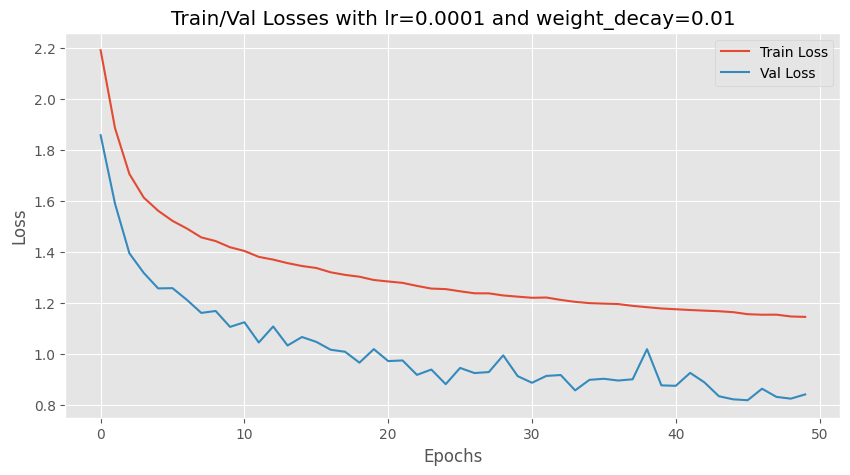

train_losses=[2.1910354457667762, 1.885515068641133, 1.7054417079026911, 1.612914664008874, 1.5612738183991586, 1.5215011915439005, 1.4914902097442406, 1.4567956080674753, 1.4423158589558742, 1.4181015230471183, 1.4035136809215158, 1.3802976806617564, 1.3695881025002639, 1.3557647577871956, 1.3444858882802884, 1.3366921480378942, 1.3197491862844566, 1.3096617693927097, 1.3024747455919774, 1.2895908077588878, 1.2837842957370924, 1.2783354092174313, 1.2664314002403045, 1.2558950299126868, 1.2538952851630225, 1.2453030315976061, 1.2374617549772382, 1.2371748757204288, 1.2290100806170432, 1.224306679097427, 1.2198427632474305, 1.2208861284109063, 1.2114717861605508, 1.203945454848166, 1.198914098404871, 1.1968907896934917, 1.195149939331733, 1.1881085527110584, 1.1829531953645385, 1.1778452594408564, 1.1748097270680664, 1.1718707065453953, 1.1693351830316594, 1.167109675340459, 1.163375664701142, 1.1554320803484568, 1.153399978096883, 1.153594998924669, 1.1465487514382777, 1.14484102926369

  0%|          | 0/6410 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1374/1374 [00:04<00:00, 284.04it/s]


Epoch [1/50], Train Loss: 1.8470, Accuracy: 37.14%, Val Loss: 1.5241, Accuracy: 51.81%


100%|██████████| 1374/1374 [00:04<00:00, 285.92it/s]


Epoch [2/50], Train Loss: 1.5530, Accuracy: 49.02%, Val Loss: 1.2129, Accuracy: 63.73%


100%|██████████| 1374/1374 [00:04<00:00, 287.79it/s]


Epoch [3/50], Train Loss: 1.4402, Accuracy: 53.15%, Val Loss: 1.1552, Accuracy: 64.18%


100%|██████████| 1374/1374 [00:07<00:00, 178.00it/s]


Epoch [4/50], Train Loss: 1.3711, Accuracy: 55.76%, Val Loss: 1.1392, Accuracy: 64.55%


100%|██████████| 1374/1374 [00:04<00:00, 281.36it/s]


Epoch [5/50], Train Loss: 1.3151, Accuracy: 57.80%, Val Loss: 0.9815, Accuracy: 70.43%


100%|██████████| 1374/1374 [00:04<00:00, 288.03it/s]


Epoch [6/50], Train Loss: 1.2770, Accuracy: 59.20%, Val Loss: 0.9938, Accuracy: 71.26%


100%|██████████| 1374/1374 [00:04<00:00, 282.81it/s]


Epoch [7/50], Train Loss: 1.2527, Accuracy: 59.88%, Val Loss: 0.9752, Accuracy: 70.05%


100%|██████████| 1374/1374 [00:06<00:00, 199.65it/s]


Epoch [8/50], Train Loss: 1.2308, Accuracy: 60.21%, Val Loss: 0.9850, Accuracy: 70.88%


100%|██████████| 1374/1374 [00:05<00:00, 274.63it/s]


Epoch [9/50], Train Loss: 1.2174, Accuracy: 60.91%, Val Loss: 0.9312, Accuracy: 74.49%


100%|██████████| 1374/1374 [00:04<00:00, 287.47it/s]


Epoch [10/50], Train Loss: 1.2043, Accuracy: 61.15%, Val Loss: 0.9593, Accuracy: 71.83%


100%|██████████| 1374/1374 [00:04<00:00, 291.67it/s]


Epoch [11/50], Train Loss: 1.1929, Accuracy: 61.80%, Val Loss: 0.9631, Accuracy: 70.76%


100%|██████████| 1374/1374 [00:05<00:00, 267.84it/s]


Epoch [12/50], Train Loss: 1.1806, Accuracy: 62.28%, Val Loss: 0.9692, Accuracy: 69.43%


100%|██████████| 1374/1374 [00:06<00:00, 202.47it/s]


Epoch [13/50], Train Loss: 1.1652, Accuracy: 62.70%, Val Loss: 0.9541, Accuracy: 70.66%


100%|██████████| 1374/1374 [00:04<00:00, 287.30it/s]


Epoch [14/50], Train Loss: 1.1625, Accuracy: 62.80%, Val Loss: 0.9741, Accuracy: 68.91%


100%|██████████| 1374/1374 [00:04<00:00, 287.67it/s]


Epoch [15/50], Train Loss: 1.1566, Accuracy: 63.08%, Val Loss: 0.9737, Accuracy: 70.82%


100%|██████████| 1374/1374 [00:05<00:00, 259.43it/s]


Epoch [16/50], Train Loss: 1.1567, Accuracy: 63.13%, Val Loss: 0.8751, Accuracy: 74.71%


100%|██████████| 1374/1374 [00:07<00:00, 180.19it/s]


Epoch [17/50], Train Loss: 1.1499, Accuracy: 62.97%, Val Loss: 1.0481, Accuracy: 66.65%


100%|██████████| 1374/1374 [00:04<00:00, 279.32it/s]


Epoch [18/50], Train Loss: 1.1439, Accuracy: 63.54%, Val Loss: 0.8630, Accuracy: 75.28%


100%|██████████| 1374/1374 [00:04<00:00, 291.33it/s]


Epoch [19/50], Train Loss: 1.1389, Accuracy: 63.69%, Val Loss: 0.8976, Accuracy: 73.15%


100%|██████████| 1374/1374 [00:05<00:00, 272.69it/s]


Epoch [20/50], Train Loss: 1.1350, Accuracy: 63.85%, Val Loss: 0.9545, Accuracy: 71.90%


100%|██████████| 1374/1374 [00:07<00:00, 193.66it/s]


Epoch [21/50], Train Loss: 1.1401, Accuracy: 63.40%, Val Loss: 0.8996, Accuracy: 71.20%


100%|██████████| 1374/1374 [00:07<00:00, 182.61it/s]


Epoch [22/50], Train Loss: 1.1370, Accuracy: 63.62%, Val Loss: 0.8619, Accuracy: 74.62%


100%|██████████| 1374/1374 [00:05<00:00, 265.43it/s]


Epoch [23/50], Train Loss: 1.1286, Accuracy: 63.60%, Val Loss: 0.9904, Accuracy: 69.15%


100%|██████████| 1374/1374 [00:05<00:00, 267.87it/s]


Epoch [24/50], Train Loss: 1.1346, Accuracy: 63.79%, Val Loss: 0.8621, Accuracy: 75.75%


100%|██████████| 1374/1374 [00:06<00:00, 208.08it/s]


Epoch [25/50], Train Loss: 1.1224, Accuracy: 64.27%, Val Loss: 0.8625, Accuracy: 76.27%


100%|██████████| 1374/1374 [00:05<00:00, 268.66it/s]


Epoch [26/50], Train Loss: 1.1269, Accuracy: 63.89%, Val Loss: 0.8625, Accuracy: 73.74%


100%|██████████| 1374/1374 [00:04<00:00, 282.90it/s]


Epoch [27/50], Train Loss: 1.1335, Accuracy: 63.91%, Val Loss: 0.9922, Accuracy: 68.91%


100%|██████████| 1374/1374 [00:05<00:00, 258.99it/s]


Epoch [28/50], Train Loss: 1.1183, Accuracy: 64.18%, Val Loss: 0.8448, Accuracy: 77.25%


100%|██████████| 1374/1374 [00:07<00:00, 185.67it/s]


Epoch [29/50], Train Loss: 1.1233, Accuracy: 64.25%, Val Loss: 0.8602, Accuracy: 74.50%


100%|██████████| 1374/1374 [00:05<00:00, 258.08it/s]


Epoch [30/50], Train Loss: 1.1153, Accuracy: 64.71%, Val Loss: 0.8223, Accuracy: 76.20%


100%|██████████| 1374/1374 [00:07<00:00, 185.82it/s]


Epoch [31/50], Train Loss: 1.1200, Accuracy: 64.24%, Val Loss: 0.8054, Accuracy: 76.74%


100%|██████████| 1374/1374 [00:08<00:00, 168.44it/s]


Epoch [32/50], Train Loss: 1.1180, Accuracy: 64.40%, Val Loss: 0.8880, Accuracy: 74.59%


100%|██████████| 1374/1374 [00:04<00:00, 279.07it/s]


Epoch [33/50], Train Loss: 1.1160, Accuracy: 64.62%, Val Loss: 0.8790, Accuracy: 74.46%


100%|██████████| 1374/1374 [00:04<00:00, 286.47it/s]


Epoch [34/50], Train Loss: 1.1170, Accuracy: 64.40%, Val Loss: 0.8968, Accuracy: 73.29%


100%|██████████| 1374/1374 [00:04<00:00, 282.95it/s]


Epoch [35/50], Train Loss: 1.1197, Accuracy: 64.31%, Val Loss: 0.9188, Accuracy: 72.13%


100%|██████████| 1374/1374 [00:06<00:00, 226.22it/s]


Epoch [36/50], Train Loss: 1.1149, Accuracy: 64.35%, Val Loss: 0.8882, Accuracy: 73.50%


100%|██████████| 1374/1374 [00:07<00:00, 177.99it/s]


Epoch [37/50], Train Loss: 1.1160, Accuracy: 64.32%, Val Loss: 0.8513, Accuracy: 74.52%


100%|██████████| 1374/1374 [00:05<00:00, 272.13it/s]


Epoch [38/50], Train Loss: 1.1176, Accuracy: 64.27%, Val Loss: 0.9460, Accuracy: 70.56%


100%|██████████| 1374/1374 [00:04<00:00, 276.95it/s]


Epoch [39/50], Train Loss: 1.1148, Accuracy: 64.44%, Val Loss: 0.9189, Accuracy: 74.13%


100%|██████████| 1374/1374 [00:04<00:00, 278.03it/s]


Epoch [40/50], Train Loss: 1.1065, Accuracy: 64.90%, Val Loss: 0.9768, Accuracy: 69.28%


100%|██████████| 1374/1374 [00:06<00:00, 223.51it/s]


Epoch [41/50], Train Loss: 1.1143, Accuracy: 64.25%, Val Loss: 0.8360, Accuracy: 76.03%


100%|██████████| 1374/1374 [00:04<00:00, 279.04it/s]


Epoch [42/50], Train Loss: 1.1072, Accuracy: 64.51%, Val Loss: 0.8524, Accuracy: 75.83%


100%|██████████| 1374/1374 [00:04<00:00, 291.58it/s]


Epoch [43/50], Train Loss: 1.1099, Accuracy: 64.68%, Val Loss: 0.8874, Accuracy: 74.67%


100%|██████████| 1374/1374 [00:04<00:00, 287.35it/s]


Epoch [44/50], Train Loss: 1.1037, Accuracy: 64.56%, Val Loss: 1.0641, Accuracy: 66.84%


100%|██████████| 1374/1374 [00:07<00:00, 177.64it/s]


Epoch [45/50], Train Loss: 1.1137, Accuracy: 64.25%, Val Loss: 0.8044, Accuracy: 76.91%


100%|██████████| 1374/1374 [00:04<00:00, 277.52it/s]


Epoch [46/50], Train Loss: 1.1141, Accuracy: 64.41%, Val Loss: 0.9721, Accuracy: 69.92%


100%|██████████| 1374/1374 [00:04<00:00, 286.35it/s]


Epoch [47/50], Train Loss: 1.1144, Accuracy: 64.25%, Val Loss: 0.8712, Accuracy: 75.46%


100%|██████████| 1374/1374 [00:05<00:00, 268.97it/s]


Epoch [48/50], Train Loss: 1.1112, Accuracy: 64.66%, Val Loss: 0.8900, Accuracy: 73.09%


100%|██████████| 1374/1374 [00:06<00:00, 205.43it/s]


Epoch [49/50], Train Loss: 1.1098, Accuracy: 64.68%, Val Loss: 1.3787, Accuracy: 60.17%


100%|██████████| 1374/1374 [00:04<00:00, 284.32it/s]


Epoch [50/50], Train Loss: 1.1131, Accuracy: 64.51%, Val Loss: 0.8365, Accuracy: 76.02%


100%|██████████| 1374/1374 [00:04<00:00, 300.49it/s]


Test Accuracy: 76.01%


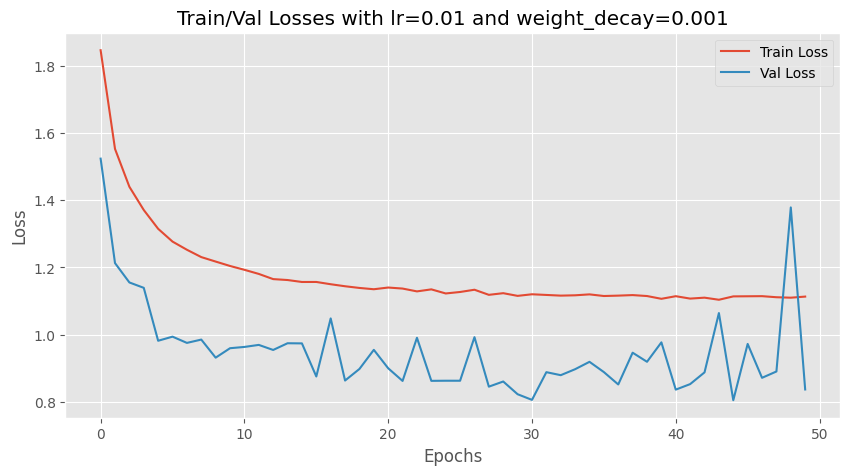

train_losses=[1.8470391807801638, 1.5530423974191156, 1.440248500622007, 1.3710636090702275, 1.315068856416366, 1.2769510915517435, 1.2526526115939323, 1.230781003363233, 1.2174485988298929, 1.204318339678687, 1.1929172899510112, 1.1806450309554426, 1.16519620568955, 1.1624566388204578, 1.1566470298259381, 1.1567081281156881, 1.1499328285943886, 1.1439210327083533, 1.138865896136545, 1.135013365461934, 1.1400959962313522, 1.137033012709268, 1.1286170771127557, 1.1346429002940561, 1.1224404106250792, 1.1268509148319314, 1.1335447501513218, 1.118347197238722, 1.1232663987881495, 1.115276413821207, 1.12001353763102, 1.1180230386520325, 1.1159943092352886, 1.1169597671435516, 1.1197227071697553, 1.114851178359037, 1.1159900582036621, 1.1175865781730312, 1.11477901439027, 1.1065264546462044, 1.1142819036629383, 1.1071513427494097, 1.1099182168588437, 1.1036906646887152, 1.1137211879915827, 1.1140629612641662, 1.1143908878151974, 1.1112145786887027, 1.1098420405025229, 1.1131142432436743]
[1

  0%|          | 0/6410 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1374/1374 [00:07<00:00, 173.00it/s]


Epoch [1/50], Train Loss: 1.8809, Accuracy: 37.02%, Val Loss: 1.4954, Accuracy: 53.71%


100%|██████████| 1374/1374 [00:05<00:00, 263.30it/s]


Epoch [2/50], Train Loss: 1.6091, Accuracy: 48.20%, Val Loss: 1.3068, Accuracy: 60.90%


100%|██████████| 1374/1374 [00:05<00:00, 268.96it/s]


Epoch [3/50], Train Loss: 1.5148, Accuracy: 51.42%, Val Loss: 1.2492, Accuracy: 61.54%


100%|██████████| 1374/1374 [00:07<00:00, 193.01it/s]


Epoch [4/50], Train Loss: 1.4477, Accuracy: 53.76%, Val Loss: 1.3918, Accuracy: 54.00%


100%|██████████| 1374/1374 [00:04<00:00, 283.48it/s]


Epoch [5/50], Train Loss: 1.3982, Accuracy: 55.28%, Val Loss: 1.1778, Accuracy: 63.75%


100%|██████████| 1374/1374 [00:05<00:00, 253.11it/s]


Epoch [6/50], Train Loss: 1.3658, Accuracy: 56.34%, Val Loss: 1.0362, Accuracy: 69.42%


100%|██████████| 1374/1374 [00:07<00:00, 179.20it/s]


Epoch [7/50], Train Loss: 1.3360, Accuracy: 57.39%, Val Loss: 0.9547, Accuracy: 72.22%


100%|██████████| 1374/1374 [00:05<00:00, 268.73it/s]


Epoch [8/50], Train Loss: 1.3128, Accuracy: 58.17%, Val Loss: 1.0138, Accuracy: 70.90%


100%|██████████| 1374/1374 [00:04<00:00, 276.18it/s]


Epoch [9/50], Train Loss: 1.2850, Accuracy: 58.85%, Val Loss: 0.9889, Accuracy: 70.97%


100%|██████████| 1374/1374 [00:07<00:00, 177.15it/s]


Epoch [10/50], Train Loss: 1.2649, Accuracy: 59.58%, Val Loss: 0.9402, Accuracy: 72.93%


100%|██████████| 1374/1374 [00:04<00:00, 281.91it/s]


Epoch [11/50], Train Loss: 1.2520, Accuracy: 60.01%, Val Loss: 0.9883, Accuracy: 71.40%


100%|██████████| 1374/1374 [00:05<00:00, 247.72it/s]


Epoch [12/50], Train Loss: 1.2388, Accuracy: 60.50%, Val Loss: 1.0670, Accuracy: 69.73%


100%|██████████| 1374/1374 [00:06<00:00, 201.23it/s]


Epoch [13/50], Train Loss: 1.2319, Accuracy: 60.63%, Val Loss: 0.9895, Accuracy: 71.42%


100%|██████████| 1374/1374 [00:04<00:00, 282.28it/s]


Epoch [14/50], Train Loss: 1.2188, Accuracy: 61.07%, Val Loss: 0.9275, Accuracy: 73.99%


100%|██████████| 1374/1374 [00:05<00:00, 265.67it/s]


Epoch [15/50], Train Loss: 1.2158, Accuracy: 61.20%, Val Loss: 0.9891, Accuracy: 71.62%


100%|██████████| 1374/1374 [00:06<00:00, 208.79it/s]


Epoch [16/50], Train Loss: 1.2061, Accuracy: 61.52%, Val Loss: 0.8807, Accuracy: 75.35%


100%|██████████| 1374/1374 [00:05<00:00, 271.86it/s]


Epoch [17/50], Train Loss: 1.1950, Accuracy: 61.88%, Val Loss: 0.8873, Accuracy: 74.37%


100%|██████████| 1374/1374 [00:04<00:00, 280.80it/s]


Epoch [18/50], Train Loss: 1.1914, Accuracy: 62.07%, Val Loss: 0.8837, Accuracy: 74.51%


100%|██████████| 1374/1374 [00:07<00:00, 175.57it/s]


Epoch [19/50], Train Loss: 1.1848, Accuracy: 62.27%, Val Loss: 0.8762, Accuracy: 74.67%


100%|██████████| 1374/1374 [00:05<00:00, 273.24it/s]


Epoch [20/50], Train Loss: 1.1738, Accuracy: 62.63%, Val Loss: 0.8780, Accuracy: 74.87%


100%|██████████| 1374/1374 [00:05<00:00, 266.70it/s]


Epoch [21/50], Train Loss: 1.1722, Accuracy: 62.73%, Val Loss: 0.8604, Accuracy: 75.22%


100%|██████████| 1374/1374 [00:07<00:00, 181.70it/s]


Epoch [22/50], Train Loss: 1.1713, Accuracy: 62.76%, Val Loss: 0.8646, Accuracy: 75.29%


100%|██████████| 1374/1374 [00:05<00:00, 268.19it/s]


Epoch [23/50], Train Loss: 1.1670, Accuracy: 62.88%, Val Loss: 0.8389, Accuracy: 75.74%


100%|██████████| 1374/1374 [00:04<00:00, 287.58it/s]


Epoch [24/50], Train Loss: 1.1507, Accuracy: 63.32%, Val Loss: 0.8010, Accuracy: 78.52%


100%|██████████| 1374/1374 [00:07<00:00, 187.61it/s]


Epoch [25/50], Train Loss: 1.1537, Accuracy: 63.23%, Val Loss: 0.8458, Accuracy: 76.02%


100%|██████████| 1374/1374 [00:04<00:00, 290.89it/s]


Epoch [26/50], Train Loss: 1.1542, Accuracy: 63.30%, Val Loss: 0.8256, Accuracy: 77.24%


100%|██████████| 1374/1374 [00:05<00:00, 262.07it/s]


Epoch [27/50], Train Loss: 1.1484, Accuracy: 63.23%, Val Loss: 0.8507, Accuracy: 75.83%


100%|██████████| 1374/1374 [00:04<00:00, 277.22it/s]


Epoch [28/50], Train Loss: 1.1458, Accuracy: 63.34%, Val Loss: 0.8553, Accuracy: 74.25%


100%|██████████| 1374/1374 [00:04<00:00, 291.23it/s]


Epoch [29/50], Train Loss: 1.1368, Accuracy: 63.89%, Val Loss: 0.8427, Accuracy: 76.67%


100%|██████████| 1374/1374 [00:07<00:00, 192.52it/s]


Epoch [30/50], Train Loss: 1.1376, Accuracy: 63.74%, Val Loss: 0.8938, Accuracy: 73.48%


100%|██████████| 1374/1374 [00:04<00:00, 275.54it/s]


Epoch [31/50], Train Loss: 1.1397, Accuracy: 63.70%, Val Loss: 0.8406, Accuracy: 76.27%


100%|██████████| 1374/1374 [00:04<00:00, 285.66it/s]


Epoch [32/50], Train Loss: 1.1299, Accuracy: 64.06%, Val Loss: 0.8630, Accuracy: 76.69%


100%|██████████| 1374/1374 [00:07<00:00, 178.06it/s]


Epoch [33/50], Train Loss: 1.1316, Accuracy: 64.00%, Val Loss: 0.7951, Accuracy: 77.53%


100%|██████████| 1374/1374 [00:04<00:00, 276.47it/s]


Epoch [34/50], Train Loss: 1.1225, Accuracy: 64.24%, Val Loss: 0.8602, Accuracy: 74.90%


100%|██████████| 1374/1374 [00:04<00:00, 293.37it/s]


Epoch [35/50], Train Loss: 1.1254, Accuracy: 64.26%, Val Loss: 0.8471, Accuracy: 77.42%


100%|██████████| 1374/1374 [00:07<00:00, 182.07it/s]


Epoch [36/50], Train Loss: 1.1269, Accuracy: 64.24%, Val Loss: 0.8225, Accuracy: 76.14%


100%|██████████| 1374/1374 [00:04<00:00, 290.47it/s]


Epoch [37/50], Train Loss: 1.1247, Accuracy: 64.25%, Val Loss: 0.8193, Accuracy: 77.51%


100%|██████████| 1374/1374 [00:04<00:00, 285.35it/s]


Epoch [38/50], Train Loss: 1.1254, Accuracy: 64.31%, Val Loss: 0.8509, Accuracy: 74.77%


100%|██████████| 1374/1374 [00:08<00:00, 168.42it/s]


Epoch [39/50], Train Loss: 1.1166, Accuracy: 64.31%, Val Loss: 0.8130, Accuracy: 77.22%


100%|██████████| 1374/1374 [00:04<00:00, 286.40it/s]


Epoch [40/50], Train Loss: 1.1187, Accuracy: 64.52%, Val Loss: 0.8376, Accuracy: 76.30%


100%|██████████| 1374/1374 [00:04<00:00, 280.87it/s]


Epoch [41/50], Train Loss: 1.1144, Accuracy: 64.64%, Val Loss: 0.7993, Accuracy: 78.20%


100%|██████████| 1374/1374 [00:04<00:00, 281.93it/s]


Epoch [42/50], Train Loss: 1.1145, Accuracy: 64.65%, Val Loss: 0.8291, Accuracy: 77.05%


100%|██████████| 1374/1374 [00:07<00:00, 181.07it/s]


Epoch [43/50], Train Loss: 1.1167, Accuracy: 64.39%, Val Loss: 0.8875, Accuracy: 74.63%


100%|██████████| 1374/1374 [00:04<00:00, 284.67it/s]


Epoch [44/50], Train Loss: 1.1073, Accuracy: 64.79%, Val Loss: 0.7972, Accuracy: 76.57%


100%|██████████| 1374/1374 [00:05<00:00, 268.77it/s]


Epoch [45/50], Train Loss: 1.1093, Accuracy: 64.74%, Val Loss: 0.8294, Accuracy: 76.31%


100%|██████████| 1374/1374 [00:07<00:00, 175.08it/s]


Epoch [46/50], Train Loss: 1.1039, Accuracy: 64.91%, Val Loss: 0.8177, Accuracy: 77.37%


100%|██████████| 1374/1374 [00:04<00:00, 281.24it/s]


Epoch [47/50], Train Loss: 1.1139, Accuracy: 64.55%, Val Loss: 0.8193, Accuracy: 78.00%


100%|██████████| 1374/1374 [00:07<00:00, 176.78it/s]


Epoch [48/50], Train Loss: 1.1136, Accuracy: 64.58%, Val Loss: 0.8135, Accuracy: 76.85%


100%|██████████| 1374/1374 [00:04<00:00, 284.85it/s]


Epoch [49/50], Train Loss: 1.1115, Accuracy: 64.75%, Val Loss: 0.8973, Accuracy: 73.41%


100%|██████████| 1374/1374 [00:05<00:00, 260.82it/s]


Epoch [50/50], Train Loss: 1.1103, Accuracy: 64.70%, Val Loss: 0.8496, Accuracy: 75.78%


100%|██████████| 1374/1374 [00:07<00:00, 195.49it/s]


Test Accuracy: 75.44%


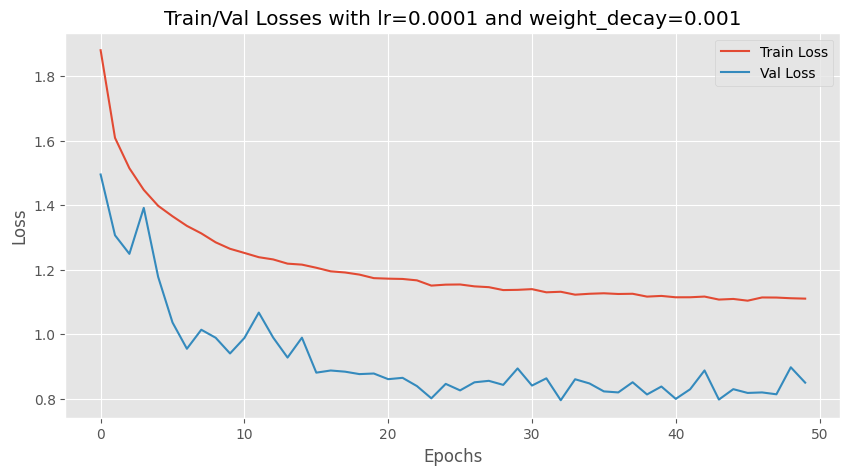

train_losses=[1.8809417907328763, 1.609108814973727, 1.514796171619814, 1.4476848237600044, 1.3982433079464387, 1.365774738379462, 1.3359507182273032, 1.312767395549185, 1.284972404782746, 1.2649035093843843, 1.2520320717704463, 1.2388136028871521, 1.231908742207075, 1.2188124501946935, 1.2157763908229269, 1.206088099060304, 1.194988242563517, 1.1914030038575858, 1.1848398016042159, 1.1738321902459943, 1.1722418662910343, 1.1713271523414648, 1.1669713314349492, 1.1507058062763555, 1.1536719435183753, 1.1542053018084926, 1.148363526418875, 1.1458345249457962, 1.1368236050404923, 1.1375548643575815, 1.1397230603486626, 1.1298868867099379, 1.1316032478664297, 1.1225474465237393, 1.1253718607325265, 1.1269009534310253, 1.1247056123921169, 1.1253703002252742, 1.1165551006700989, 1.1187042814242114, 1.1144488172347013, 1.1145288614954294, 1.1166809036955818, 1.1073369678580631, 1.109315468952083, 1.1039139047195312, 1.113927180776823, 1.1136274342231929, 1.1114863623183528, 1.110291498904109

In [ ]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from torch.optim import SGD, Adam, RMSprop


def create_model(input_size, hidden_size, output_size, batch_normalization):
    return AircraftNet(input_size=input_size, hidden_size=hidden_size, output_size=output_size, batch_normalization=batch_normalization).to(device)


num_epochs = 50
params = [(RMSprop, 0.0001, 0.01), (SGD, 0.0001, 0.01), (SGD, 0.01, 0.001), (Adam, 0.0001, 0.001)]
best_with_batch_normalization = pd.DataFrame(columns=['opt', 'best_acc', 'lr', 'weight_decay'])

for param in params:
    model = create_model(IMAGE_HEIGHT*IMAGE_WIDTH*3, 256, NUM_CLASSES, batch_normalization=True)
    print(f"Params lr={param[1]}, w={param[2]}, opt={param[0].__name__}")
    train_losses, val_losses, best_with_batch_normalization = train_model(model, param[0], train_data_loader, val_data_loader, num_epochs, param[1], weight_decay=param[2], results_df=best_with_batch_normalization)
    accuracy = test_model(model, test_data_loader)
    print(f"Test Accuracy: {100 * accuracy:.2f}%")

    with plt.style.context('ggplot'):
        plt.figure(figsize=(10, 5))
        plt.plot(range(num_epochs), train_losses, label='Train Loss')
        plt.plot(range(num_epochs), val_losses, label='Val Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title(f'Train/Val Losses with lr={param[1]} and weight_decay={param[2]}')
        plt.legend()
        plt.show()

    print(f"{train_losses=}\n{val_losses}")
